# Initial stuff

<html>
    <body style="background-color:powderblue;">
        <div class="alert alert-success">
            <h2 style="text-align:center;style:Modern;color:purple;">
                Import libraries
            </h2>
        </div>
    </body>
</html>            

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import plotly
import seaborn as sns
import plotly.graph_objs as go
from IPython.display import IFrame

import osmnx as ox
import networkx as nx
import geopandas as gpd
from folium.plugins import MarkerCluster, HeatMap
import folium

from functools import partial
from math import sin, cos, sqrt, atan2, radians, degrees
from scipy.interpolate import interp1d
from openpyxl.styles import Font, alignment, borders
from dateutil import parser
import openpyxl
import collections
import itertools
import copy
import time
import re

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

import psutil
import sys
import os

%matplotlib inline
ox.config(log_file=True, log_console=True, use_cache=True)

In [3]:
def generator(beginning, ending):
    while beginning < ending:
        yield beginning
        beginning += 1

# how far is it between these two nodes as the crow flies?
def flight_dist(point_1,point_2):
    # approximate radius of earth in meter
    R = 6378.0

    lat1, lon1, lat2, lon2 = *point_1, *point_2

    dlat = radians(lat2) - radians(lat1)
    dlon = radians(lon2) - radians(lon1)

    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R*c*1000
        
# how long is route in meters?    
def distance(yxo, yxd):
    orig_node = ox.get_nearest_node(NYC, yxo)
    dest_node = ox.get_nearest_node(NYC, yxd)
    route_length = nx.shortest_path_length(NYC, orig_node, dest_node, weight='length')
    return route_length

def route(node1, node2):
    orig_node = ox.get_nearest_node(NYC, node1)
    dest_node = ox.get_nearest_node(NYC, node2)
    rout = nx.shortest_path(NYC, orig_node, dest_node, weight='length')
    return rout

# Return traveled dist for each rider respectively, from pick up to drop off point in sharing mode
def find_distance_sharing(origin_list, destination_list):
    temp_lst = []  # temp_lst store traveled distance for each rider until drop off point
    destination_list = tuple([_+10000 for _ in destination_list])
    seq_pup_doff = origin_list + destination_list
    for rider in origin_list:
        rider_seq = seq_pup_doff[origin_list.index(rider):seq_pup_doff.index(rider+10000)+1]
        each_one_traveled_dist = 0
        for each in range(len(rider_seq) - 1):
            if rider_seq[each] >= 10000:
                prior = ds_rider['d_lat'][rider_seq[each]-10000], ds_rider['d_lon'][rider_seq[each]-10000]
            else:
                prior = ds_rider['p_lat'][rider_seq[each]], ds_rider['p_lon'][rider_seq[each]]
            if rider_seq[each+1] >= 10000:
                following = ds_rider['d_lat'][rider_seq[each+1]-10000], ds_rider['d_lon'][rider_seq[each+1]-10000]
            else:
                following = ds_rider['p_lat'][rider_seq[each+1]], ds_rider['p_lon'][rider_seq[each+1]]
            each_one_traveled_dist += distance(prior, following)
        temp_lst.append(each_one_traveled_dist)
    return temp_lst

# Removing selected taxi and riders from taxi, origin and destination dictionaries
def del_dict_item(selected_taxi, comb_dic, index_dic):
#     print('selected_taxi: ', selected_taxi)
    Taxis_copy.remove(selected_taxi)
    for each_rider in comb_dic[selected_taxi][index_dic[selected_taxi]]:
#         print('removed_rider: ', each_rider)
        riders_copy.remove(each_rider)

<html>
    <body style="background-color:powderblue;">
        <div class="alert alert-success">
            <h2 style="text-align:center;style:Modern;color:purple;">
                getting NYC network
            </h2>
        </div>
    </body>
</html>            

In [35]:
NYC1 = ox.load_graphml(filename='NYC1.graphml', folder='dataset-nyc/graphml-nyc/')

NYC = ox.load_graphml(filename='NYC.graphml', folder='dataset-nyc/graphml-nyc/')

<html>
    <body style="background-color:powderblue;">
        <div class="alert alert-success">
            <h2 style="text-align:center;style:Modern;color:purple;">
                import dataset
            </h2>
        </div>
    </body>
</html>  

In [ ]:
lst=[]
for i in sorted(os.listdir('dataset-nyc/raw data/whole day')):
    lst.append(pd.read_csv('dataset-nyc/raw data/whole day/'+i))
ds_TheWholeDay = pd.concat(lst,ignore_index=True)
ds_TheWholeDay.rename(columns={'pickup_longitude':'p_lon', 'pickup_latitude':'p_lat', 
                               'dropoff_longitude':'d_lon', 'dropoff_latitude':'d_lat'}, inplace=True)
ds_TheWholeDay = ds_TheWholeDay[['pickup_datetime','p_lon','p_lat','d_lon','d_lat',
                                 'trip_distance','passenger_count']]
to_datetime_fmt = partial(pd.to_datetime, format='%Y-%m-%d %H:%M:%S %Z')
ds_TheWholeDay['pickup_datetime'] = ds_TheWholeDay['pickup_datetime'].apply(to_datetime_fmt)

mask =  (ds_TheWholeDay['p_lon'] > -74.000233) & \
        (ds_TheWholeDay['p_lon'] < -73.960054) & \
        (ds_TheWholeDay['p_lat'] > 40.739814) & \
        (ds_TheWholeDay['p_lat'] < 40.762440) & \
        (ds_TheWholeDay['d_lon'] > -74.000233) & \
        (ds_TheWholeDay['d_lon'] < -73.960054) & \
        (ds_TheWholeDay['d_lat'] > 40.739814) & \
        (ds_TheWholeDay['d_lat'] < 40.762440)
ds_wholeDay_scop_allday = ds_TheWholeDay.loc[mask].copy()
ds_wholeDay_scop_allday.reset_index(drop=True,inplace=True)

mask = (ds_wholeDay_scop_allday['pickup_datetime'].dt.time >= parser.parse('{:0>2d}:30:00'.format(7)).time()) & \
       (ds_wholeDay_scop_allday['pickup_datetime'].dt.time <= parser.parse('{:0>2d}:30:00'.format(19)).time())
ds_wholeDay_scop_7_19 = ds_wholeDay_scop_allday.loc[mask].copy()
ds_wholeDay_scop_7_19.reset_index(drop=True,inplace=True)


mask =  (ds_wholeDay_scop_7_19['p_lon'] is not None) & \
        (ds_wholeDay_scop_7_19['p_lon'] is not None) & \
        (ds_wholeDay_scop_7_19['p_lat'] is not None) & \
        (ds_wholeDay_scop_7_19['p_lat'] is not None) & \
        (ds_wholeDay_scop_7_19['d_lon'] is not None) & \
        (ds_wholeDay_scop_7_19['d_lon'] is not None) & \
        (ds_wholeDay_scop_7_19['d_lat'] is not None) & \
        (ds_wholeDay_scop_7_19['d_lat'] is not None) & \
        (ds_wholeDay_scop_7_19['trip_distance'] > 0)
ds_wholeDay_clean = ds_wholeDay_scop_7_19.loc[mask].copy()
ds_wholeDay_clean.reset_index(drop=True,inplace=True)


mask = (ds_wholeDay_clean['passenger_count'] == 1)
ds_wholeDay_one = ds_wholeDay_clean.loc[mask].copy()
ds_wholeDay_one.reset_index(drop=True,inplace=True)
        

angle_lst_r=[]
distanc_lst = []
for each in ds_wholeDay_one.iterrows():
    
    ridero = each[1]['p_lat'], each[1]['p_lon']
    riderd = each[1]['d_lat'], each[1]['d_lon']
    try:
        distanc = distance2(ridero, riderd)
        if distanc < 400:
            ds_wholeDay_one.drop(each[0],inplace=True)
        else:
            xyo = each[1]['p_lon'],each[1]['p_lat']
            xyd = each[1]['d_lon'],each[1]['d_lat']
            angle_lst_r.append(radians(find_angle(xyo,xyd)))
            distanc_lst.append(distanc)
    except:
        ds_wholeDay_one.drop(each[0],inplace=True)
ds_wholeDay_one.reset_index(drop=True,inplace=True)
ds_wholeDay_one['angle_r']=pd.Series(angle_lst_r)
ds_wholeDay_one['dist']=pd.Series(distanc_lst)

all_raw = ds_wholeDay_scop_7_19
all_clean = ds_wholeDay_clean
one_clean = ds_wholeDay_one

cleansing_percent = (all_raw.shape[0]-all_clean.shape[0])*100/all_raw.shape[0]
one_percent = one_clean.shape[0]*100/all_clean.shape[0]
less_2000m = all_clean[all_clean.dist<=2000].count()['dist']*100/all_clean.shape[0]
less_800m = all_clean[all_clean.dist<=800].count()['dist']*100/all_clean.shape[0]
print('{:25}: {}'.format('cleansing_percent', cleansing_percent))
print('{:25}: {}'.format('one_percent', one_percent))
print('{:25}: {}'.format('less_2000m', less_2000m))
print('{:25}: {}'.format('less_800m', less_800m))
print('{:25}: {}'.format('trip_distance_ave', all_clean.describe()['dist']['mean']))


print('{:24} {}'.format('ds_TheWholeDay',len(ds_TheWholeDay)))
print('{:24} {}'.format('ds_wholeDay_scop_allday',len(ds_wholeDay_scop_allday)))
print('{:24} {}'.format('ds_wholeDay_scop_7_19',len(ds_wholeDay_scop_7_19)))
print('{:24} {}'.format('ds_wholeDay_clean',len(ds_wholeDay_clean)))
print('{:24} {}'.format('ds_wholeDay_one',len(ds_wholeDay_one)))
print('{:24} {}'.format('ds_morningPeak',len(ds_morningPeak)))
print('{:24} {}'.format('ds_wholeDay',len(ds_wholeDay)))


In [5]:
ds_taxi = pd.read_csv('dataset-nyc/taxi 2016-06-15 clean.csv')

ds_taxi = ds_taxi[:150]
ds_rider = ds_wholeDay_one[:100]

<html>
    <body style="background-color:powderblue;">
        <div class="alert alert-warning">
            <h2 style="text-align:center;style:Modern;color:purple;">
                folium.Map
            </h2>
        </div>
    </body>
</html>            

In [ ]:
tile = ['Stamen Terrain', 'Stamen Toner', 'Stamen Watercolor', 
        'OpenStreetMap', 
        'Mapbox Bright', 
        'CartoDB positron', 
        'CartoDB dark_matter']
map_taxi = folium.Map(location=(40.751738, -73.987042), tiles=tile[0], zoom_start=13)
marker_cluster_taxi = MarkerCluster().add_to(map_taxi)

# add a marker for every record in the filtered data, use a clustered view
for each in ds_taxi.iterrows():
    lat, lon = [each[1]['p_lat'], each[1]['p_lon']]
    folium.Marker([lat, lon], 
                  popup='lat: {}<br>lon: {}'.format(lat, lon), 
                  icon=folium.Icon(color='purple', icon_color='white', icon='taxi', prefix='fa'), 
                  tooltip=str(each[0])).add_to(map_taxi)
display(map_taxi)


map_rider = folium.Map(location=(40.751738, -73.987042), tiles=tile[0], zoom_start=13)
marker_cluster_rider = MarkerCluster().add_to(map_rider)

# add a marker for every record in the filtered data, use a clustered view
data = []
for each in ds_rider.iterrows():
    lat, lon = [each[1]['p_lat'], each[1]['p_lon']]
    data.append((lat, lon)) # lat, lon
#     folium.Marker([lat, lon], 
#                   popup='lat: {}<br>lon: {}'.format(lat, lon), 
#                   icon=folium.Icon(color='green', icon_color='white', icon='thumbs-up', prefix='fa'), 
#                   tooltip=str(each[0])).add_to(map_rider)
    lat, lon = [each[1]['d_lat'], each[1]['d_lon']]
    data.append((lat, lon)) # lat, lon
#     folium.Marker([lat, lon], 
#                   popup='lat: {}<br>lon: {}'.format(lat, lon), 
#                   icon=folium.Icon(color='lightblue', icon_color='white', icon='thumbs-down', prefix='fa'), 
#                   tooltip=str(each[0])).add_to(map_rider)
    
HeatMap(data).add_to(map_rider)
display(map_rider)

<html>
    <body style="background-color:powderblue;">
        <div class="alert alert-success">
            <h2 style="text-align:center;style:Modern;color:purple;">
                define variables
            </h2>
        </div>
    </body>
</html>            

In [6]:
SIF_list = [1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8]
file = open('log.txt', 'w')
Taxis = list(ds_taxi.index)
riders = list(ds_rider.index)
the_holy_container = dict() # {0:{():const, ():const}, 1:{():const, ():}}
the_holy_container_3 = dict()

riders_num, Zeros, Ones, Twos, Threes, Fours = [], [], [], [], [], []
vkt_Share, vkt_ShareSingle, vkt_rejected = [], [], []

output = pd.ExcelWriter('output.xlsx')

# Data frame for active cars in network
df_active_cars = pd.DataFrame(columns=['#zero',
                                       '#one',
                                       '#two',
                                       '#three',
                                       '#four',
                                       'Sum_taxi',
                                       'Sum_rider',
                                       'Nan+one',
                                       'Missing',
                                       'Total', 
                                       'vehicle occupancy rate'])

share_single_list, rejected_request = [], []
vor,vor1 = [],[] # vehicle occupancy rate
statistics_plot_single_sen1, statistics_plot_share = [], {_:{} for _ in SIF_list}
statistics_plot_sen2 = {}

# Senarios

<html>
    <body style="background-color:powderblue;">
        <div class="alert alert-info">
            <h2 style="text-align:center;style:Modern;color:purple;">
                Senario base
            </h2>
        </div>
    </body>
</html>            

In [7]:
vkt_base_dict = {}
for each in ds_rider.iterrows():
    ridero = each[1]['p_lat'], each[1]['p_lon']
    riderd = each[1]['d_lat'], each[1]['d_lon']
    dist = distance(ridero, riderd)
    vkt_base_dict[each[0]] = dist
vkt_base = [sum(vkt_base_dict.values())]*len(SIF_list)
print(vkt_base)

[164234.32800000004, 164234.32800000004, 164234.32800000004, 164234.32800000004, 164234.32800000004, 164234.32800000004, 164234.32800000004, 164234.32800000004, 164234.32800000004]


<html>
    <body style="background-color:powderblue;">
        <div class="alert alert-info">
            <h2 style="text-align:center;style:Modern;color:purple;">
                Senario 1
            </h2>
        </div>
    </body>
</html>            

In [9]:
df_sen1 = pd.DataFrame(index=riders,columns=Taxis, dtype='float64')
for each_person in riders:
    each_row = []
    for each_taxi in Taxis:
        ridero = ds_rider.loc[each_person]['p_lat'], ds_rider.loc[each_person]['p_lon']
        taxi_loc = ds_taxi.loc[each_taxi]['p_lat'], ds_taxi.loc[each_taxi]['p_lon']
        dist = distance(ridero, taxi_loc)
        each_row.append(dist)
    df_sen1.loc[each_person,:] = each_row

vkt_single = 0
for _ in df_sen1.iterrows():
    row, col = df_sen1.stack().idxmin()
    
    vkt_single_each = df_sen1.loc[row,col]
    ridero = ds_rider.loc[row]['p_lat'], ds_rider.loc[row]['p_lon']
    riderd = ds_rider.loc[row]['d_lat'], ds_rider.loc[row]['d_lon']
    vkt_single_each += distance(ridero, riderd)
    statistics_plot_single_sen1.append(vkt_single_each)
    vkt_single+=vkt_single_each
    
    df_sen1.drop(index=row,columns=col,inplace=True)
vkt_single = [vkt_single]*len(SIF_list)
print(vkt_single)

KeyboardInterrupt: 

<html>
    <body style="background-color:powderblue;">
        <div class="alert alert-info">
            <h2 style="text-align:center;style:Modern;color:purple;">
                Senario 2
            </h2>
        </div>
    </body>
</html>            

In [ ]:
df_sen2 = pd.DataFrame(index=riders,columns=Taxis, dtype='float64')
for each_person in riders:
    each_row = []
    for each_taxi in Taxis:
        ridero = ds_rider.loc[each_person]['p_lat'], ds_rider.loc[each_person]['p_lon']
        taxi_loc = ds_taxi.loc[each_taxi]['p_lat'], ds_taxi.loc[each_taxi]['p_lon']
        dist = distance(ridero, taxi_loc)
        each_row.append(dist)
    df_sen2.loc[each_person,:] = each_row

vkt_without_comb = 0
Taxis_sen2, riders_sen2 = Taxis.copy(), riders.copy()
rejected_rider_senario2, __shared = set(), set()
for _ in df_sen2.iterrows():
    taxi_group = {each_taxi:df_sen2.sort_values(by=each_taxi)[each_taxi][:4].sum() 
                  for each_taxi in Taxis_sen2}
    min_taxi = min(taxi_group, key=taxi_group.get)
    min_rider = df_sen2.sort_values(by=min_taxi)[min_taxi][:4].index.tolist()
    
    
    if len(min_rider)<4:
        pass
    else:
        
        # ------------------------------------------------------------------------------------------------
        #                                       Shortest path (Start)
        # ------------------------------------------------------------------------------------------------
        # path_find dictionary has two keys {1:[origin sequence], 2:[destination sequence]}
        path_find = {1:[], 2:[]}
        # Find chosen combination from comb dictionary
        chosen_rider = min_rider
        [path_find[1].append(i) for i in chosen_rider]
        [path_find[2].append(i) for i in chosen_rider]

        # Find permutation of riders for chosen taxi in both origin and destination
        path_find_perm = collections.defaultdict(list)
        for each_perm in itertools.permutations(path_find[1]):
            path_find_perm[1].append(each_perm)
            path_find_perm[2].append(each_perm)
        
        # Calculating traveled distance for each permutation in =================================== origin
        # path_find_perm_dist = {1:[]}
        path_find_perm_dist = collections.defaultdict(list)
        for each_perm in range(len(path_find_perm[1])):
            sum_dist = 0
            for each_rider in range(len(path_find_perm[1][each_perm]) - 1):
                rider1 = ds_rider['p_lat'][path_find_perm[1][each_perm][each_rider]], ds_rider['p_lon'][path_find_perm[1][each_perm][each_rider]]
                rider2 = ds_rider['p_lat'][path_find_perm[1][each_perm][each_rider + 1]], ds_rider['p_lon'][path_find_perm[1][each_perm][each_rider + 1]]
                sum_dist += distance(rider1, rider2)
            taxi_loc = ds_taxi['p_lat'][min_taxi], ds_taxi['p_lon'][min_taxi]
            first_rider = ds_rider['p_lat'][path_find_perm[1][each_perm][0]], ds_rider['p_lon'][path_find_perm[1][each_perm][0]]
            path_find_perm_dist[1].append(sum_dist + distance(taxi_loc, first_rider))

        # Calculating traveled distance for each permutation in destination based on origin permutations
        # that are in path_find_perm[1] list, i.e. we try all origin sequence to get minimum distance
        # path_find_perm_dist = {1:[], 2:[[first_origin_min], [second_origin_min], [third_origin_min],..]}
        for each_perm1 in range(len(path_find_perm[1])):
            list_temporary = []
            # Calculating traveled distance for each permutation in ========================== destination
            for each_perm2 in range(len(path_find_perm[2])):
                sum_dist = 0
                for each_rider in range(len(path_find_perm[2][each_perm2]) - 1):
                    rider1 = ds_rider['d_lat'][path_find_perm[2][each_perm2][each_rider]], ds_rider['d_lon'][path_find_perm[2][each_perm2][each_rider]]
                    rider2 = ds_rider['d_lat'][path_find_perm[2][each_perm2][each_rider + 1]], ds_rider['d_lon'][path_find_perm[2][each_perm2][each_rider + 1]]
                    sum_dist += distance(rider1, rider2)
                last_rider = ds_rider['p_lat'][path_find_perm[1][each_perm1][3]], ds_rider['p_lon'][path_find_perm[1][each_perm1][3]]
                first_rider = ds_rider['d_lat'][path_find_perm[2][each_perm2][0]], ds_rider['d_lon'][path_find_perm[2][each_perm2][0]]
                dist_in_o = path_find_perm_dist[1][each_perm1]
                list_temporary.append(sum_dist + distance(last_rider, first_rider) + dist_in_o)
            path_find_perm_dist[2].append(list_temporary)

        # I don't care how many minimum are in each list of key(2):[  ] of path_find_perm_dist?
        # We have minimum in destination per origin, min_2 = [number of permutation in origin]
        min_2 = [min(path_find_perm_dist[2][i]) for i in range(len(path_find_perm_dist[2]))]

        # By index_min_1 we can find which sequence of origin is the best for get the minimum traveled distance
        index_min_1 = min_2.index(min(min_2))
        path_min_1 = path_find_perm[1][index_min_1]
        min_1 = path_find_perm_dist[1][index_min_1]

        # Getting index of permutation that its traveled distance in (destination + origin) become the lowest
        # and Return rider's destination sequence in path_min_2 as a list
        index_min_2 = path_find_perm_dist[2][index_min_1].index(min(path_find_perm_dist[2][index_min_1]))
        path_min_2 = path_find_perm[2][index_min_2]

        
        
        
        
        
        p1_share, p2_share, p3_share, p4_share = find_distance_sharing(path_min_1, path_min_2)

        p1_single = vkt_base_dict[path_min_1[0]]
        p2_single = vkt_base_dict[path_min_1[1]]
        p3_single = vkt_base_dict[path_min_1[2]]
        p4_single = vkt_base_dict[path_min_1[3]]

        # Share mode over individual mode for all chosen riders
        lst1 = np.array([p1_share, p2_share, p3_share, p4_share], dtype='float')
        lst2 = np.array([p1_single, p2_single, p3_single, p4_single], dtype='float')
        divide = lst1 / lst2
        divide[divide > 2] = np.NaN
        so1, so2, so3, so4 = divide


        # ==========================================================================
        #                                 NaN_value
        # ==========================================================================
        number_of_NaN_value = np.count_nonzero(np.isnan(divide))

        # nan rider
        index_of_Nan = [each_rider[0] for each_rider in np.argwhere(np.isnan(divide)).tolist()]
        index_of_non_Nan = [each_rider[0] for each_rider in np.argwhere(~np.isnan(divide)).tolist()]

        if number_of_NaN_value == 3 or number_of_NaN_value == 4:
#             print('4'*80)
#             print(divide, '\n', path_min_1, '\n', chosen_rider, sep='')
            df_sen2.drop(index=min_rider,inplace=True)
            [rejected_rider_senario2.add(path_min_1[each_index]) for each_index in index_of_Nan]
            [rejected_rider_senario2.add(path_min_1[each_index]) for each_index in index_of_non_Nan]
            
        elif number_of_NaN_value == 2 or number_of_NaN_value == 1:
            chosen_rider = [path_min_1[each_index] for each_index in index_of_non_Nan]
            [rejected_rider_senario2.add(path_min_1[i]) for i in index_of_Nan]
            havij = [path_min_1[i] for i in index_of_Nan]
            # --------------------------------------------------------------------------------------------
            #                                       2_Shortest path (Start)
            # --------------------------------------------------------------------------------------------
            # path_find dictionary has two keys {1:[origin sequence], 2:[destination sequence]}
            path_find = collections.defaultdict(list)
            # Find chosen combination from comb dictionary
            [path_find[1].append(i) for i in chosen_rider]
            [path_find[2].append(i) for i in chosen_rider]

            # Find permutation of riders for chosen taxi in both origin and destination
            path_find_perm = collections.defaultdict(list)
            for each_perm in itertools.permutations(path_find[1]):
                path_find_perm[1].append(each_perm)
                path_find_perm[2].append(each_perm)
            # Calculating traveled distance for each permutation in =============================== origin
            # path_find_perm_dist = {1:[]}
            path_find_perm_dist = collections.defaultdict(list)
            for each_perm in range(len(path_find_perm[1])):
                sum_dist = 0
                for each_rider in range(len(path_find_perm[1][each_perm]) - 1):
                    rider1 = ds_rider['p_lat'][path_find_perm[1][each_perm][each_rider]], ds_rider['p_lon'][path_find_perm[1][each_perm][each_rider]]
                    rider2 = ds_rider['p_lat'][path_find_perm[1][each_perm][each_rider + 1]], ds_rider['p_lon'][path_find_perm[1][each_perm][each_rider + 1]]
                    sum_dist += distance(rider1, rider2)
                taxi_loc = ds_taxi['p_lat'][min_taxi], ds_taxi['p_lon'][min_taxi]
                first_rider = ds_rider['p_lat'][path_find_perm[1][each_perm][0]], ds_rider['p_lon'][path_find_perm[1][each_perm][0]]
                path_find_perm_dist[1].append(sum_dist + distance(taxi_loc, first_rider))

            # Calculating traveled distance for each permutation in destination based on origin permutations
            # that are in path_find_perm[1] list, i.e. we try all origin sequence to get minimum distance
            # path_find_perm_dist = {1:[], 2:[[first_origin_min], [second_origin_min], [third_origin_min],..]}
            # کل مسافت پیموده شده از نقطه شروع حرکت تاکسی تا پیاده شدن آخرین نفر
            for each_perm1 in range(len(path_find_perm[1])):
                list_temporary = []
                # Calculating traveled distance for each permutation in ====================== destination
                for each_perm2 in range(len(path_find_perm[2])):
                    sum_dist = 0
                    for each_rider in range(len(path_find_perm[2][each_perm2]) - 1):
                        rider1 = ds_rider['d_lat'][path_find_perm[2][each_perm2][each_rider]], ds_rider['d_lon'][path_find_perm[2][each_perm2][each_rider]]
                        rider2 = ds_rider['d_lat'][path_find_perm[2][each_perm2][each_rider + 1]], ds_rider['d_lon'][path_find_perm[2][each_perm2][each_rider + 1]]
                        sum_dist += distance(rider1, rider2)

                    if number_of_NaN_value == 2:
                        last_rider = ds_rider['p_lat'][path_find_perm[1][each_perm1][1]], ds_rider['p_lon'][path_find_perm[1][each_perm1][1]]
                        first_rider = ds_rider['d_lat'][path_find_perm[2][each_perm2][0]], ds_rider['d_lon'][path_find_perm[2][each_perm2][0]]
                    elif number_of_NaN_value == 1:
                        last_rider = ds_rider['p_lat'][path_find_perm[1][each_perm1][2]], ds_rider['p_lon'][path_find_perm[1][each_perm1][2]]
                        first_rider = ds_rider['d_lat'][path_find_perm[2][each_perm2][0]], ds_rider['d_lon'][path_find_perm[2][each_perm2][0]]
                    dist_in_o = path_find_perm_dist[1][each_perm1]
                    list_temporary.append(sum_dist + distance(last_rider, first_rider) + dist_in_o)
                path_find_perm_dist[2].append(list_temporary)
            # I don't care how many minimum are in each list of key(2):[  ] of path_find_perm_dist?
            # We have minimum in destination per origin, min_2 = [number of permutation in origin]
            min_2 = [min(path_find_perm_dist[2][i]) for i in range(len(path_find_perm_dist[2]))]

            # By index_min_1 we can find which sequence of origin is the best for get the minimum traveled distance
            index_min_1 = min_2.index(min(min_2))
            path_min_1 = path_find_perm[1][index_min_1]
            min_1 = path_find_perm_dist[1][index_min_1]

            # Getting index of permutation that its traveled distance in (destination + origin) become the lowest and
            # Return rider's destination sequence in path_min_2 as a list
            index_min_2 = path_find_perm_dist[2][index_min_1].index(min(path_find_perm_dist[2][index_min_1]))
            path_min_2 = path_find_perm[2][index_min_2]


            # Compute distance in sharing mode(each taxi travel with riders)
            vkt_without_comb += min(min_2)
            df_sen2.drop(index=chosen_rider,columns=min_taxi,inplace=True)
            Taxis_sen2.remove(min_taxi)
            
#             print('2'*80)
#             print(divide, '\n', path_min_1, '\n', chosen_rider, sep='')
#             print('havij: ',havij)
            df_sen2.drop(index=havij,inplace=True)
            [__shared.add(i) for i in chosen_rider]

        else:
            # Compute distance in sharing mode(each taxi travel with riders)
            vkt_without_comb += min(min_2)
            df_sen2.drop(index=chosen_rider,columns=min_taxi,inplace=True)
            Taxis_sen2.remove(min_taxi)
        
#             print('0'*80)
#             print(divide, '\n', path_min_1, '\n', chosen_rider, sep='')
            [__shared.add(i) for i in chosen_rider]

        for _,__ in zip(path_min_1,[p1_share, p2_share, p3_share, p4_share]):
                statistics_plot_sen2[_]=__

        
        
        
# print('delivered: ', __shared)
# print('rejected_rider_senario2: ', rejected_rider_senario2)
# print('__&rejected_rider_senario2: ',__shared&rejected_rider_senario2)
# print('len(__shared), len(rejected_rider_senario2), len(df_sen2): ',
#       len(__shared), len(rejected_rider_senario2), len(df_sen2))

display(df_sen2)
df_sen2_size = len(df_sen2)
sum_extra_missing = 0
for _ in df_sen2.iterrows():
    row, col = df_sen2.stack().idxmin()
    sum_extra_missing_ = df_sen2.loc[row,col]
    ridero = ds_rider['p_lat'][row], ds_rider['p_lon'][row]
    riderd = ds_rider['d_lat'][row], ds_rider['d_lon'][row]
    sum_extra_missing_ += distance(ridero, riderd) 
    sum_extra_missing += sum_extra_missing_
    statistics_plot_sen2[_[0]] = sum_extra_missing_
    df_sen2.drop(index=row,columns=col,inplace=True)
    Taxis_sen2.remove(col)
# print('sum_extra_missing: ',sum_extra_missing)






sum_extra_reject = 0
df_reject = pd.DataFrame(index=rejected_rider_senario2,columns=Taxis, dtype='float64')
for each_person in rejected_rider_senario2:
    each_row = []
    for each_taxi in Taxis:
        ridero = ds_rider.loc[each_person]['p_lat'], ds_rider.loc[each_person]['p_lon']
        taxi_loc = ds_taxi.loc[each_taxi]['p_lat'], ds_taxi.loc[each_taxi]['p_lon']
        dist = distance(ridero, taxi_loc)
        each_row.append(dist)
    df_reject.loc[each_person,:] = each_row
for _ in df_reject.iterrows():
    row, col = df_reject.stack().idxmin()
    sum_extra_reject_ = df_reject.loc[row,col]
    ridero = ds_rider.loc[row]['p_lat'], ds_rider.loc[row]['p_lon']
    riderd = ds_rider.loc[row]['d_lat'], ds_rider.loc[row]['d_lon']
    sum_extra_reject_ += distance(ridero, riderd)
    sum_extra_reject += sum_extra_reject_
    statistics_plot_sen2[_[0]] = sum_extra_reject_
    df_reject.drop(index=row,columns=col,inplace=True)
# print('sum_extra_reject: ',sum_extra_reject)





vkt_without_comb = [vkt_without_comb+sum_extra_missing+sum_extra_reject]*len(SIF_list)
sum_extra_missing = [sum_extra_missing]*len(SIF_list)
sum_extra_reject = [sum_extra_reject]*len(SIF_list)
print(vkt_without_comb)

<html>
    <body style="background-color:powderblue;">
        <div class="alert alert-info">
            <h2 style="text-align:center;style:Modern;color:purple;">
                Main Body
            </h2>
        </div>
    </body>
</html>            

In [ ]:
# For loop to find optimum SIF ============================================== Sharing importance factor == SIF
for SIF in SIF_list:
    print('\n\nSIF: ', SIF)
    # sheet for each SIF
    # Data frame for results - selected taxi and so on
    df = pd.DataFrame(columns=['Taxi',
                               'Sequence in the origin', 'Sequence in the destination',
                               'to first rider', 'origin', 'transfer', 'destination',
                               '(Sharing)', ' ', ' ', ' ',
                               '(Single)', ' ', ' ', ' ',
                               'Detour factor', ' ', ' ', ' '])
    df.loc[' '] = [' ',
                   ' ', ' ',
                   ' ', ' ', ' ', ' ',
                   'P1', 'P2', 'P3', 'P4',
                   'P1', 'P2', 'P3', 'P4',
                   'P1', 'P2', 'P3', 'P4']

    # define variables
    # For each SIF we should Retrieve Taxis, riders
    Taxis_copy, riders_copy = Taxis.copy(), riders.copy()
    zeros_, ones_, twos_, threes_, fours_ = 0, 0, 0, 0, 0  # Number of taxis with this riders
    vkt_share = {}  # Distance each taxi travel in sharing mode
    rejected_rider = []
    share_single_value = 0
    # Check all taxis
    for taxi_index_ in generator(0, len(Taxis_copy)):
#         print('taxi_index_: ', taxi_index_)
        file.write((('\n=\n taxi index {} \n'.format(taxi_index_)).
                            replace(' ', ' ' * 40, 1)).replace('=', '=' * 100, 2))
        check = True  # Check if there is at least one taxi in comb_locO_com_cons_min dictionary
        check_3 = True  # Check if there is at least one taxi in comb_locO_com_cons_min_3 dictionary

        # if rider be in taxis's catchment area, it will be in taxi's list
        taxi_catchment = collections.defaultdict(list)
        for each_taxi in Taxis_copy:
            point1 = ds_taxi['p_lat'][each_taxi], ds_taxi['p_lon'][each_taxi]
            for each_person in riders_copy:
                point2 = ds_rider['p_lat'][each_person], ds_rider['p_lon'][each_person]
                if flight_dist(point1, point2) <= 600:
                    taxi_catchment[each_taxi].append(each_person)
        
        duplicate_key = set()
        taxi_key = list(taxi_catchment.keys())
        for _ in range(len(taxi_key)):
            for __ in range(_+1,len(taxi_key)):
                if taxi_catchment[taxi_key[_]] == taxi_catchment[taxi_key[__]]:
                    duplicate_key.add(taxi_key[__])  
        for _ in duplicate_key:
            del taxi_catchment[_]
        
        # ----------------------------------------------------------------------------------------------------
        #                                                   4
        # ----------------------------------------------------------------------------------------------------
        # Find 4-combination of riders for each taxi
        comb = collections.defaultdict(list)
        for each_taxi in taxi_catchment:
            if len(taxi_catchment[each_taxi]) >= 4:
                for each_comb in itertools.combinations(taxi_catchment[each_taxi], 4):
                    comb[each_taxi].append(each_comb)
        # Calculating center of points for each group of riders for each taxi in origin, destination
        comb_locO_com = collections.defaultdict(list)
        comb_locD_com = collections.defaultdict(list)
        for each_taxi in comb:
            for each_comb in comb[each_taxi]:
                lat_in_o = [ds_rider['p_lat'][each_rider] for each_rider in each_comb]
                lon_in_o = [ds_rider['p_lon'][each_rider] for each_rider in each_comb]
                comb_locO_com[each_taxi].append((sum(lat_in_o)/len(lat_in_o), sum(lon_in_o)/len(lon_in_o)))

                lat_in_d = [ds_rider['d_lat'][each_rider] for each_rider in each_comb]
                lon_in_d = [ds_rider['d_lon'][each_rider] for each_rider in each_comb]
                comb_locD_com[each_taxi].append((sum(lat_in_d)/len(lat_in_d), sum(lon_in_d)/len(lon_in_d)))
        
        # ----------------------------------------------------------------------------------------------------
        #                   Calculating constraints (const_origin + const_taxi + const_destination)
        # ----------------------------------------------------------------------------------------------------
        comb_locO_com_cons = collections.defaultdict(list)
        for each_taxi in comb_locO_com:
            the_holy_container[each_taxi] = dict()
            for each_comb in range(len(comb_locO_com[each_taxi])):
                the_comb = comb[each_taxi][each_comb]
                if the_comb in the_holy_container[each_taxi]:
                    Constraint = the_holy_container[each_taxi][the_comb]
                else:
                    Constraint = 0
                    for each_rider in comb[each_taxi][each_comb]:
                        ridero = ds_rider['p_lat'][each_rider], ds_rider['p_lon'][each_rider]
                        riderd = ds_rider['d_lat'][each_rider], ds_rider['d_lon'][each_rider]
                        taxi_loc = ds_taxi['p_lat'][each_taxi], ds_taxi['p_lon'][each_taxi]
                        com_o_loc = comb_locO_com[each_taxi][each_comb]
                        com_d_loc = comb_locD_com[each_taxi][each_comb]
                        Constraint += flight_dist(com_o_loc, ridero) + flight_dist(com_d_loc, riderd)
                    taxi_loc = flight_dist(com_o_loc, taxi_loc)
                    Constraint += taxi_loc
                    the_holy_container[each_taxi][the_comb] = Constraint
                    
                
                comb_locO_com_cons[each_taxi].append(Constraint)

        # Minimum values of Constraints
        comb_locO_com_cons_min = dict()
        for each_taxi in comb_locO_com_cons:
            comb_locO_com_cons_min[each_taxi] = min(comb_locO_com_cons[each_taxi])
        # If comb_locO_com_cons dictionary be empty then comb_locO_com_cons_min will be empty
        # i.e. minimum calculating get ValueError so we can't calculate four in Comparison minimum of 3 and 4 riders
        try:
            minimum = min(comb_locO_com_cons_min, key=comb_locO_com_cons_min.get) #taxi's num
        except ValueError:
            check = False

        # Index of minimum values of Constraints
        comb_locO_com_cons_min_index = dict()
        for each_taxi in comb_locO_com_cons:
            index = comb_locO_com_cons[each_taxi].index(min(comb_locO_com_cons[each_taxi]))
            comb_locO_com_cons_min_index[each_taxi] = index


        # ----------------------------------------------------------------------------------------------------
        #                                                  3
        # ----------------------------------------------------------------------------------------------------
        # Find 3-combination of riders for each taxi
        comb_3 = collections.defaultdict(list)
        for each_taxi in taxi_catchment:
            if len(taxi_catchment[each_taxi]) >= 3:
                for each_comb in itertools.combinations(taxi_catchment[each_taxi], 3):
                    comb_3[each_taxi].append(each_comb)

        # Calculating center of points for each group of riders for each taxi in origin, destination
        comb_locO_com_3 = collections.defaultdict(list)
        comb_locD_com_3 = collections.defaultdict(list)
        for each_taxi in comb_3:
            for each_comb in comb_3[each_taxi]:
                lat_in_o = [ds_rider['p_lat'][each_rider] for each_rider in each_comb]
                lon_in_o = [ds_rider['p_lon'][each_rider] for each_rider in each_comb]
                comb_locO_com_3[each_taxi].append((sum(lat_in_o)/len(lat_in_o), sum(lon_in_o)/len(lon_in_o)))
                
                lat_in_d = [ds_rider['d_lat'][each_rider] for each_rider in each_comb]
                lon_in_d = [ds_rider['d_lon'][each_rider] for each_rider in each_comb]
                comb_locD_com_3[each_taxi].append((sum(lat_in_d)/len(lat_in_d), sum(lon_in_d)/len(lon_in_d)))
                
        # ----------------------------------------------------------------------------------------------------
        #                   Calculating constraints_3 (const_origin + const_taxi + const_destination)
        # ----------------------------------------------------------------------------------------------------
        comb_locO_com_cons_3 = collections.defaultdict(list)
        for each_taxi in comb_locO_com_3:
            the_holy_container_3[each_taxi] = dict()
            for each_comb in range(len(comb_locO_com_3[each_taxi])):
                the_comb = comb_3[each_taxi][each_comb]
                if the_comb in the_holy_container_3[each_taxi]:
                    Constraint = the_holy_container_3[each_taxi][the_comb]
                else:
                    Constraint = 0
                    for each_rider in comb_3[each_taxi][each_comb]:
                        ridero = ds_rider['p_lat'][each_rider], ds_rider['p_lon'][each_rider]
                        riderd = ds_rider['d_lat'][each_rider], ds_rider['d_lon'][each_rider]
                        taxi_loc = ds_taxi['p_lat'][each_taxi], ds_taxi['p_lon'][each_taxi]
                        com_o_loc = comb_locO_com_3[each_taxi][each_comb]
                        com_d_loc = comb_locD_com_3[each_taxi][each_comb]
                        Constraint += flight_dist(com_o_loc, ridero) + flight_dist(com_d_loc, riderd)                    
                    taxi_loc = flight_dist(com_o_loc, taxi_loc)
                    Constraint += taxi_loc
                    the_holy_container_3[each_taxi][the_comb] = Constraint
                    
                    
                comb_locO_com_cons_3[each_taxi].append(SIF*(Constraint))

        # Minimum values of Constraints_3
        comb_locO_com_cons_min_3 = dict()
        for each_taxi in comb_locO_com_cons_3:
            comb_locO_com_cons_min_3[each_taxi] = min(comb_locO_com_cons_3[each_taxi])
        # If comb_locO_com_cons_3 dictionary be empty then comb_locO_com_cons_min_3 will be empty
        # i.e. minimum_3 calculating get ValueError so we can't calculate three in Comparison minimum of 3 and 4 riders
        try:
            minimum_3 = min(comb_locO_com_cons_min_3, key=comb_locO_com_cons_min_3.get) #taxi's num
        except ValueError:
            check_3 = False

        # Index of minimum values of Constraints_3
        comb_locO_com_cons_min_index_3 = collections.defaultdict(list)
        for each_taxi in comb_locO_com_cons_3:
            index = comb_locO_com_cons_3[each_taxi].index(min(comb_locO_com_cons_3[each_taxi]))
            comb_locO_com_cons_min_index_3[each_taxi] = index

        # terminate the SIF loop
        # If comb_locO_com_cons and comb_locO_com_cons_3 dictionaries be empty then terminate loop
        # i.e. if there are no riders in catchment area of any taxis then stop this loop and go for new SIF
        if not bool(comb_locO_com_cons) and not bool(comb_locO_com_cons_3):
            break


        # ----------------------------------------------------------------------------------------------------
        #                                  Comparison minimum of 3 and 4 riders
        # ----------------------------------------------------------------------------------------------------
        try:
            four = comb_locO_com_cons[minimum][comb_locO_com_cons_min_index[minimum]] / 4
        except (IndexError, NameError, KeyError):
            four = 100000
        try:
            three = comb_locO_com_cons_3[minimum_3][comb_locO_com_cons_min_index_3[minimum_3]] / 3
        except (IndexError, NameError, KeyError):
            three = 100000

        # We want to know do we have any taxi with 4 riders, by boolean operator (check)
        if four <= three and check:
            # if four choose
            fours_ += 1

            # ------------------------------------------------------------------------------------------------
            #                                       Shortest path (Start)
            # ------------------------------------------------------------------------------------------------
            # path_find dictionary has two keys {1:[origin sequence], 2:[destination sequence]}
            path_find = {1:[], 2:[]}
            # Find chosen combination from comb dictionary
            chosen_rider = comb[minimum][comb_locO_com_cons_min_index[minimum]]
            [path_find[1].append(i) for i in chosen_rider]
            [path_find[2].append(i) for i in chosen_rider]

            # Find permutation of riders for chosen taxi in both origin and destination
            path_find_perm = collections.defaultdict(list)
            for each_perm in itertools.permutations(path_find[1]):
                path_find_perm[1].append(each_perm)
                path_find_perm[2].append(each_perm)
            file.write('{0:41} ::= {1}\n'.format('path_find_perm', dict(path_find_perm)))
            # Calculating traveled distance for each permutation in =================================== origin
            # path_find_perm_dist = {1:[]}
            path_find_perm_dist = collections.defaultdict(list)
            for each_perm in range(len(path_find_perm[1])):
                sum_dist = 0
                for each_rider in range(len(path_find_perm[1][each_perm]) - 1):
                    rider1 = ds_rider['p_lat'][path_find_perm[1][each_perm][each_rider]], ds_rider['p_lon'][path_find_perm[1][each_perm][each_rider]]
                    rider2 = ds_rider['p_lat'][path_find_perm[1][each_perm][each_rider + 1]], ds_rider['p_lon'][path_find_perm[1][each_perm][each_rider + 1]]
                    sum_dist += distance(rider1, rider2)
                taxi_loc = ds_taxi['p_lat'][minimum], ds_taxi['p_lon'][minimum]
                first_rider = ds_rider['p_lat'][path_find_perm[1][each_perm][0]], ds_rider['p_lon'][path_find_perm[1][each_perm][0]]
                path_find_perm_dist[1].append(sum_dist + distance(taxi_loc, first_rider))

            # Calculating traveled distance for each permutation in destination based on origin permutations
            # that are in path_find_perm[1] list, i.e. we try all origin sequence to get minimum distance
            # path_find_perm_dist = {1:[], 2:[[first_origin_min], [second_origin_min], [third_origin_min],..]}
            # کل مسافت پیموده شده از نقطه شروع حرکت تاکسی تا پیاده شدن آخرین نفر
            for each_perm1 in range(len(path_find_perm[1])):
                list_temporary = []
                # Calculating traveled distance for each permutation in ========================== destination
                for each_perm2 in range(len(path_find_perm[2])):
                    sum_dist = 0
                    for each_rider in range(len(path_find_perm[2][each_perm2]) - 1):
                        rider1 = ds_rider['d_lat'][path_find_perm[2][each_perm2][each_rider]], ds_rider['d_lon'][path_find_perm[2][each_perm2][each_rider]]
                        rider2 = ds_rider['d_lat'][path_find_perm[2][each_perm2][each_rider + 1]], ds_rider['d_lon'][path_find_perm[2][each_perm2][each_rider + 1]]
                        sum_dist += distance(rider1, rider2)
                    last_rider = ds_rider['p_lat'][path_find_perm[1][each_perm1][3]], ds_rider['p_lon'][path_find_perm[1][each_perm1][3]]
                    first_rider = ds_rider['d_lat'][path_find_perm[2][each_perm2][0]], ds_rider['d_lon'][path_find_perm[2][each_perm2][0]]
                    dist_in_o = path_find_perm_dist[1][each_perm1]
                    list_temporary.append(sum_dist + distance(last_rider, first_rider) + dist_in_o)
                path_find_perm_dist[2].append(list_temporary)
            file.write('{0:41} ::= {1}\n'.format('path_find_perm_dist', dict(path_find_perm_dist)))
            # I don't care how many minimum are in each list of key(2):[  ] of path_find_perm_dist?
            # We have minimum in destination per origin, min_2 = [number of permutation in origin]
            min_2 = [min(path_find_perm_dist[2][i]) for i in range(len(path_find_perm_dist[2]))]

            # By index_min_1 we can find which sequence of origin is the best for get the minimum traveled distance
            index_min_1 = min_2.index(min(min_2))
            path_min_1 = path_find_perm[1][index_min_1]
            min_1 = path_find_perm_dist[1][index_min_1]

            # Getting index of permutation that its traveled distance in (destination + origin) become the lowest and
            # Return rider's destination sequence in path_min_2 as a list
            index_min_2 = path_find_perm_dist[2][index_min_1].index(min(path_find_perm_dist[2][index_min_1]))
            path_min_2 = path_find_perm[2][index_min_2]

            # ------------------------------------------------------------------------------------------------
            #                                       Put results in df (Data Frame)
            # ------------------------------------------------------------------------------------------------
            taxi_loc = ds_taxi['p_lat'][minimum], ds_taxi['p_lon'][minimum]
            first_rider = ds_rider['p_lat'][path_min_1[0]], ds_rider['p_lon'][path_min_1[0]]
            to_first_rider = distance(taxi_loc, first_rider)
            origin = min_1 - to_first_rider
            last_rider = ds_rider['p_lat'][path_min_1[3]], ds_rider['p_lon'][path_min_1[3]]
            first_rider = ds_rider['d_lat'][path_min_2[0]], ds_rider['d_lon'][path_min_2[0]]
            transfer = distance(last_rider, first_rider)
            destination = min(min_2) - transfer - min_1

            p1_share, p2_share, p3_share, p4_share = find_distance_sharing(path_min_1, path_min_2)

            p1_single = vkt_base_dict[path_min_1[0]]
            p2_single = vkt_base_dict[path_min_1[1]]
            p3_single = vkt_base_dict[path_min_1[2]]
            p4_single = vkt_base_dict[path_min_1[3]]

            # Share mode over individual mode for all chosen riders
            lst1 = np.array([p1_share, p2_share, p3_share, p4_share], dtype='float')
            lst2 = np.array([p1_single, p2_single, p3_single, p4_single], dtype='float')
            divide = lst1 / lst2
            divide[divide > 2] = np.NaN
            so1, so2, so3, so4 = divide

            
            # ==========================================================================
            #                                 NaN_value
            # ==========================================================================
            # number_of_non_NaN_value = np.count_nonzero(~np.isnan(divide))
            number_of_NaN_value = np.count_nonzero(np.isnan(divide))

            # nan rider
            index_of_Nan = [each_rider[0] for each_rider in np.argwhere(np.isnan(divide)).tolist()]
            [rejected_rider.append(path_min_1[each_index]) for each_index in index_of_Nan]
            index_of_non_Nan = [each_rider[0] for each_rider in np.argwhere(~np.isnan(divide)).tolist()]

            if number_of_NaN_value == 3 or number_of_NaN_value == 4:
                fours_ -= 1
                if number_of_NaN_value == 3:
                    [rejected_rider.append(path_min_1[each_index]) for each_index in index_of_non_Nan]
                    ones_ += 1
                else:
                    zeros_ += 1
                pass
            elif number_of_NaN_value == 2 or number_of_NaN_value == 1:
                fours_ -= 1
                if number_of_NaN_value == 2:
                    twos_ += 1
                else:
                    threes_ += 1
                # --------------------------------------------------------------------------------------------
                #                                       2_Shortest path (Start)
                # --------------------------------------------------------------------------------------------
                # path_find dictionary has two keys {1:[origin sequence], 2:[destination sequence]}
                path_find = collections.defaultdict(list)
                # Find chosen combination from comb dictionary
                chosen_rider = [path_min_1[each_index] for each_index in index_of_non_Nan]
                [path_find[1].append(i) for i in chosen_rider]
                [path_find[2].append(i) for i in chosen_rider]

                # Find permutation of riders for chosen taxi in both origin and destination
                path_find_perm = collections.defaultdict(list)
                for each_perm in itertools.permutations(path_find[1]):
                    path_find_perm[1].append(each_perm)
                    path_find_perm[2].append(each_perm)
                file.write('{0:41} ::= {1}\n'.format('path_find_perm', dict(path_find_perm)))
                # Calculating traveled distance for each permutation in =============================== origin
                # path_find_perm_dist = {1:[]}
                path_find_perm_dist = collections.defaultdict(list)
                for each_perm in range(len(path_find_perm[1])):
                    sum_dist = 0
                    for each_rider in range(len(path_find_perm[1][each_perm]) - 1):
                        rider1 = ds_rider['p_lat'][path_find_perm[1][each_perm][each_rider]], ds_rider['p_lon'][path_find_perm[1][each_perm][each_rider]]
                        rider2 = ds_rider['p_lat'][path_find_perm[1][each_perm][each_rider + 1]], ds_rider['p_lon'][path_find_perm[1][each_perm][each_rider + 1]]
                        sum_dist += distance(rider1, rider2)
                    taxi_loc = ds_taxi['p_lat'][minimum], ds_taxi['p_lon'][minimum]
                    first_rider = ds_rider['p_lat'][path_find_perm[1][each_perm][0]], ds_rider['p_lon'][path_find_perm[1][each_perm][0]]
                    path_find_perm_dist[1].append(sum_dist + distance(taxi_loc, first_rider))

                # Calculating traveled distance for each permutation in destination based on origin permutations
                # that are in path_find_perm[1] list, i.e. we try all origin sequence to get minimum distance
                # path_find_perm_dist = {1:[], 2:[[first_origin_min], [second_origin_min], [third_origin_min],..]}
                # کل مسافت پیموده شده از نقطه شروع حرکت تاکسی تا پیاده شدن آخرین نفر
                for each_perm1 in range(len(path_find_perm[1])):
                    list_temporary = []
                    # Calculating traveled distance for each permutation in ====================== destination
                    for each_perm2 in range(len(path_find_perm[2])):
                        sum_dist = 0
                        for each_rider in range(len(path_find_perm[2][each_perm2]) - 1):
                            rider1 = ds_rider['d_lat'][path_find_perm[2][each_perm2][each_rider]], ds_rider['d_lon'][path_find_perm[2][each_perm2][each_rider]]
                            rider2 = ds_rider['d_lat'][path_find_perm[2][each_perm2][each_rider + 1]], ds_rider['d_lon'][path_find_perm[2][each_perm2][each_rider + 1]]
                            sum_dist += distance(rider1, rider2)
                        
                        if number_of_NaN_value == 2:
                            last_rider = ds_rider['p_lat'][path_find_perm[1][each_perm1][1]], ds_rider['p_lon'][path_find_perm[1][each_perm1][1]]
                            first_rider = ds_rider['d_lat'][path_find_perm[2][each_perm2][0]], ds_rider['d_lon'][path_find_perm[2][each_perm2][0]]
                        elif number_of_NaN_value == 1:
                            last_rider = ds_rider['p_lat'][path_find_perm[1][each_perm1][2]], ds_rider['p_lon'][path_find_perm[1][each_perm1][2]]
                            first_rider = ds_rider['d_lat'][path_find_perm[2][each_perm2][0]], ds_rider['d_lon'][path_find_perm[2][each_perm2][0]]
                        dist_in_o = path_find_perm_dist[1][each_perm1]
                        list_temporary.append(sum_dist + distance(last_rider, first_rider) + dist_in_o)
                    path_find_perm_dist[2].append(list_temporary)
                file.write('{0:41} ::= {1}\n'.format('path_find_perm_dist', dict(path_find_perm_dist)))
                # I don't care how many minimum are in each list of key(2):[  ] of path_find_perm_dist?
                # We have minimum in destination per origin, min_2 = [number of permutation in origin]
                min_2 = [min(path_find_perm_dist[2][i]) for i in range(len(path_find_perm_dist[2]))]

                # By index_min_1 we can find which sequence of origin is the best for get the minimum traveled distance
                index_min_1 = min_2.index(min(min_2))
                path_min_1 = path_find_perm[1][index_min_1]
                min_1 = path_find_perm_dist[1][index_min_1]

                # Getting index of permutation that its traveled distance in (destination + origin) become the lowest and
                # Return rider's destination sequence in path_min_2 as a list
                index_min_2 = path_find_perm_dist[2][index_min_1].index(min(path_find_perm_dist[2][index_min_1]))
                path_min_2 = path_find_perm[2][index_min_2]

                # --------------------------------------------------------------------------------------------
                #                                       Put results in df (Data Frame)
                # --------------------------------------------------------------------------------------------
                taxi_loc = ds_taxi['p_lat'][minimum], ds_taxi['p_lon'][minimum]
                first_rider = ds_rider['p_lat'][path_min_1[0]], ds_rider['p_lon'][path_min_1[0]]
                to_first_rider = distance(taxi_loc, first_rider)
                origin = min_1 - to_first_rider
                if number_of_NaN_value == 2:
                    last_rider = ds_rider['p_lat'][path_min_1[1]], ds_rider['p_lon'][path_min_1[1]]
                    first_rider = ds_rider['d_lat'][path_min_2[0]], ds_rider['d_lon'][path_min_2[0]]
                    transfer = distance(last_rider, first_rider)

                    p1_share, p2_share = find_distance_sharing(path_min_1, path_min_2)
                    p3_share = np.NaN
                    p4_share = np.NaN
                    
                    p1_single = vkt_base_dict[path_min_1[0]]
                    p2_single = vkt_base_dict[path_min_1[1]]
                    p3_single = np.NaN
                    p4_single = np.NaN
                if number_of_NaN_value == 1:
                    last_rider = ds_rider['p_lat'][path_min_1[2]], ds_rider['p_lon'][path_min_1[2]]
                    first_rider = ds_rider['d_lat'][path_min_2[0]], ds_rider['d_lon'][path_min_2[0]]
                    transfer = distance(last_rider, first_rider)

                    p1_share, p2_share, p3_share = find_distance_sharing(path_min_1, path_min_2)
                    p4_share = np.NaN
                    
                    p1_single = vkt_base_dict[path_min_1[0]]
                    p2_single = vkt_base_dict[path_min_1[1]]
                    p3_single = vkt_base_dict[path_min_1[2]]
                    p4_single = np.NaN
                destination = min(min_2) - transfer - min_1
                # Share mode over individual mode for all chosen riders
                lst1 = np.array([p1_share, p2_share, p3_share, p4_share], dtype='float')
                lst2 = np.array([p1_single, p2_single, p3_single, p4_single], dtype='float')
                divide = lst1 / lst2
                so1, so2, so3, so4 = divide
                

                # Compute distance in sharing mode(each taxi travel with riders)
                vkt_share[minimum] = min(min_2)

            else:
                # Compute distance in sharing mode(each taxi travel with riders)
                vkt_share[minimum] = min(min_2)
            for _,__ in zip(path_min_1,[p1_share, p2_share, p3_share, p4_share]):
                statistics_plot_share[SIF][_]=__
            df.loc['{}'.format(taxi_index_ + 1)] = [minimum,
                                                    path_min_1, path_min_2,
                                                    to_first_rider, origin, transfer, destination,
                                                    p1_share, p2_share, p3_share, p4_share,
                                                    p1_single, p2_single, p3_single, p4_single,
                                                    round(so1, 2), round(so2, 2), round(so3, 2), round(so4, 2)]

            # Removing selected taxi and riders
            del_dict_item(minimum, comb, comb_locO_com_cons_min_index)

            file.write('{0:41} ::= {1}\n'.format('index_min_1', index_min_1))
            file.write('{0:41} ::= {1}\n'.format('path_min_1', path_min_1))
            file.write('{0:41} ::= {1}\n'.format('min_1', min_1))
            file.write('{0:41} ::= {1}\n'.format('index_min_2', index_min_2))
            file.write('{0:41} ::= {1}\n'.format('path_min_2', path_min_2))
            file.write('{0:41} ::= {1}\n'.format('min_2', min_2))

        
        # We want to know do we have any taxi with 3 riders, by boolean operator (check_3)
        elif four > three and check_3:
            # if three choose
            threes_ += 1
            
            # ------------------------------------------------------------------------------------------------
            #                                      Shortest path_3 (Start)
            # ------------------------------------------------------------------------------------------------
            # path_find dictionary has two keys {1:[origin sequence], 2:[destination sequence]}
            path_find = {1:[], 2:[]}
            # Find chosen combination from comb_3 dictionary
            chosen_rider = comb_3[minimum_3][comb_locO_com_cons_min_index_3[minimum_3]]
            [path_find[1].append(i) for i in chosen_rider]
            [path_find[2].append(i) for i in chosen_rider]

            # Find permutation of riders for chosen taxi in both origin and destination
            path_find_perm = collections.defaultdict(list)
            for each_perm in itertools.permutations(path_find[1]):
                path_find_perm[1].append(each_perm)
                path_find_perm[2].append(each_perm)
            file.write('{0:41} ::= {1}\n'.format('path_find_perm', dict(path_find_perm)))
            # Calculating traveled distance for each permutation in =================================== origin
            # path_find_perm_dist = {1:[]}
            path_find_perm_dist = collections.defaultdict(list)
            for each_perm in range(len(path_find_perm[1])):
                sum_dist = 0
                for each_rider in range(len(path_find_perm[1][each_perm]) - 1):
                    rider1 = ds_rider['p_lat'][path_find_perm[1][each_perm][each_rider]], ds_rider['p_lon'][path_find_perm[1][each_perm][each_rider]]
                    rider2 = ds_rider['p_lat'][path_find_perm[1][each_perm][each_rider + 1]], ds_rider['p_lon'][path_find_perm[1][each_perm][each_rider + 1]]
                    sum_dist += distance(rider1, rider2)
                taxi_loc = ds_taxi['p_lat'][minimum_3], ds_taxi['p_lon'][minimum_3]
                first_rider = ds_rider['p_lat'][path_find_perm[1][each_perm][0]], ds_rider['p_lon'][path_find_perm[1][each_perm][0]]
                path_find_perm_dist[1].append(sum_dist + distance(taxi_loc, first_rider))

            # Calculating traveled distance for each permutation in destination based on origin permutations
            # that are in path_find_perm[1] list, i.e. we try all origin sequence to get minimum distance
            # path_find_perm_dist = {1:[], 2:[[first_origin_min], [second_origin_min], [third_origin_min],..]}
            # کل مسافت پیموده شده از نقطه شروع حرکت تاکسی تا پیاده شدن آخرین نفر
            for each_perm1 in range(len(path_find_perm[1])):
                list_temporary = []
                # Calculating traveled distance for each permutation in ========================== destination
                for each_perm2 in range(len(path_find_perm[2])):
                    sum_dist = 0
                    for each_rider in range(len(path_find_perm[2][each_perm2]) - 1):
                        rider1 = ds_rider['d_lat'][path_find_perm[2][each_perm2][each_rider]], ds_rider['d_lon'][path_find_perm[2][each_perm2][each_rider]]
                        rider2 = ds_rider['d_lat'][path_find_perm[2][each_perm2][each_rider + 1]], ds_rider['d_lon'][path_find_perm[2][each_perm2][each_rider + 1]]
                        sum_dist += distance(rider1, rider2)
                    last_rider = ds_rider['p_lat'][path_find_perm[1][each_perm1][2]], ds_rider['p_lon'][path_find_perm[1][each_perm1][2]]
                    first_rider = ds_rider['d_lat'][path_find_perm[2][each_perm2][0]], ds_rider['d_lon'][path_find_perm[2][each_perm2][0]]
                    dist_in_o = path_find_perm_dist[1][each_perm1]
                    list_temporary.append(sum_dist + distance(last_rider, first_rider) + dist_in_o)
                path_find_perm_dist[2].append(list_temporary)
            file.write('{0:41} ::= {1}\n'.format('path_find_perm_dist', dict(path_find_perm_dist)))
            # I don't care how many minimum are in each list of key(2):[  ] of path_find_perm_dist?
            # We have minimum in destination per origin's, min_2 = [number of permutation in origin]
            min_2 = [min(path_find_perm_dist[2][i]) for i in range(len(path_find_perm_dist[2]))]

            # By index_min_1 we can find which sequence of origin is the best for get the minimum traveled distance
            index_min_1 = min_2.index(min(min_2))
            path_min_1 = path_find_perm[1][index_min_1]
            min_1 = path_find_perm_dist[1][index_min_1]

            # Getting index of permutation that its traveled distance in (destination + origin) become the lowest and
            # Return rider's destination sequence in path_min_2 as a list
            index_min_2 = path_find_perm_dist[2][index_min_1].index(min(path_find_perm_dist[2][index_min_1]))
            path_min_2 = path_find_perm[2][index_min_2]

            # ------------------------------------------------------------------------------------------------
            #                                       Put results in df (Data Frame)
            # ------------------------------------------------------------------------------------------------
            taxi_loc = ds_taxi['p_lat'][minimum_3], ds_taxi['p_lon'][minimum_3]
            first_rider = ds_rider['p_lat'][path_min_1[0]], ds_rider['p_lon'][path_min_1[0]]
            to_first_rider = distance(taxi_loc, first_rider)
            origin = min_1 - to_first_rider
            last_rider = ds_rider['p_lat'][path_min_1[2]], ds_rider['p_lon'][path_min_1[2]]
            first_rider = ds_rider['d_lat'][path_min_2[0]], ds_rider['d_lon'][path_min_2[0]]
            transfer = distance(last_rider, first_rider)
            destination = min(min_2) - transfer

            p1_share, p2_share, p3_share = find_distance_sharing(path_min_1, path_min_2)
            p4_share = np.NAN
                                             
            p1_single = vkt_base_dict[path_min_1[0]]
            p2_single = vkt_base_dict[path_min_1[1]]
            p3_single = vkt_base_dict[path_min_1[2]]
            p4_single = np.NAN

            # Share mode over individual mode for all chosen riders
            lst1 = np.array([p1_share, p2_share, p3_share], dtype='float')
            lst2 = np.array([p1_single, p2_single, p3_single], dtype='float')
            divide = lst1 / lst2
            divide[divide > 2] = np.NaN
            so1, so2, so3 = divide
            so4 = np.NaN

            
            # ==========================================================================
            #                                 NaN_value
            # ========================================================================== 
            # number_of_non_NaN_value = np.count_nonzero(~np.isnan(divide))
            number_of_NaN_value = np.count_nonzero(np.isnan(divide))

            # nan rider
            index_of_Nan = [each_rider[0] for each_rider in np.argwhere(np.isnan(divide)).tolist()]
            [rejected_rider.append(path_min_1[each_index]) for each_index in index_of_Nan]
            index_of_non_Nan = [each_rider[0] for each_rider in np.argwhere(~np.isnan(divide)).tolist()]

            if number_of_NaN_value == 2 or number_of_NaN_value == 3:
                threes_ -= 1
                if number_of_NaN_value == 2:
                    [rejected_rider.append(path_min_1[each_index]) for each_index in index_of_non_Nan]
                    ones_ += 1
                else:
                    zeros_ += 1
                pass
            elif number_of_NaN_value == 1:
                threes_ -= 1
                twos_ += 1
                # --------------------------------------------------------------------------------------------
                #                                       2_Shortest path (Start)
                # --------------------------------------------------------------------------------------------
                # path_find dictionary has two keys {1:[origin sequence], 2:[destination sequence]}
                path_find = collections.defaultdict(list)
                # Find chosen combination from comb dictionary
                chosen_rider = [path_min_1[i] for i in index_of_non_Nan]
                [path_find[1].append(i) for i in chosen_rider]
                [path_find[2].append(i) for i in chosen_rider]
                
                # Find permutation of riders for chosen taxi in both origin and destination
                path_find_perm = collections.defaultdict(list)
                for each_perm in itertools.permutations(path_find[1]):
                    path_find_perm[1].append(each_perm)
                    path_find_perm[2].append(each_perm)
                file.write('{0:41} ::= {1}\n'.format('path_find_perm', dict(path_find_perm)))
                # Calculating traveled distance for each permutation in =============================== origin
                # path_find_perm_dist = {1:[]}
                path_find_perm_dist = collections.defaultdict(list)
                for each_perm in range(len(path_find_perm[1])):
                    sum_dist = 0
                    for each_rider in range(len(path_find_perm[1][each_perm]) - 1):
                        rider1 = ds_rider['p_lat'][path_find_perm[1][each_perm][each_rider]], ds_rider['p_lon'][path_find_perm[1][each_perm][each_rider]]
                        rider2 = ds_rider['p_lat'][path_find_perm[1][each_perm][each_rider + 1]], ds_rider['p_lon'][path_find_perm[1][each_perm][each_rider + 1]]
                        sum_dist += distance(rider1, rider2)
                    taxi_loc = ds_taxi['p_lat'][minimum_3], ds_taxi['p_lon'][minimum_3]
                    first_rider = ds_rider['p_lat'][path_find_perm[1][each_perm][0]], ds_rider['p_lon'][path_find_perm[1][each_perm][0]]
                    path_find_perm_dist[1].append(sum_dist + distance(taxi_loc, first_rider))

                # Calculating traveled distance for each permutation in destination based on origin permutations
                # that are in path_find_perm[1] list, i.e. we try all origin sequence to get minimum distance
                # path_find_perm_dist = {1:[], 2:[[first_origin_min], [second_origin_min], [third_origin_min],..]}
                # کل مسافت پیموده شده از نقطه شروع حرکت تاکسی تا پیاده شدن آخرین نفر
                for each_perm1 in range(len(path_find_perm[1])):
                    list_temporary = []
                    # Calculating traveled distance for each permutation in ====================== destination
                    for each_perm2 in range(len(path_find_perm[2])):
                        sum_dist = 0
                        for each_rider in range(len(path_find_perm[2][each_perm2]) - 1):
                            rider1 = ds_rider['d_lat'][path_find_perm[2][each_perm2][each_rider]], ds_rider['d_lon'][path_find_perm[2][each_perm2][each_rider]]
                            rider2 = ds_rider['d_lat'][path_find_perm[2][each_perm2][each_rider + 1]], ds_rider['d_lon'][path_find_perm[2][each_perm2][each_rider + 1]]
                            sum_dist += distance(rider1, rider2)
                        
                        last_rider = ds_rider['p_lat'][path_find_perm[1][each_perm1][1]], ds_rider['p_lon'][path_find_perm[1][each_perm1][1]]
                        first_rider = ds_rider['d_lat'][path_find_perm[2][each_perm2][0]], ds_rider['d_lon'][path_find_perm[2][each_perm2][0]]
                        dist_in_o = path_find_perm_dist[1][each_perm1]
                        list_temporary.append(sum_dist + distance(last_rider, first_rider) + dist_in_o)
                    path_find_perm_dist[2].append(list_temporary)
                file.write('{0:41} ::= {1}\n'.format('path_find_perm_dist', dict(path_find_perm_dist)))
                # I don't care how many minimum are in each list of key(2):[  ] of path_find_perm_dist?
                # We have minimum in destination per origin, min_2 = [number of permutation in origin]
                min_2 = [min(path_find_perm_dist[2][i]) for i in range(len(path_find_perm_dist[2]))]

                # By index_min_1 we can find which sequence of origin is the best for get the minimum traveled distance
                index_min_1 = min_2.index(min(min_2))
                path_min_1 = path_find_perm[1][index_min_1]
                min_1 = path_find_perm_dist[1][index_min_1]

                # Getting index of permutation that its traveled distance in (destination + origin) become the lowest and
                # Return rider's destination sequence in path_min_2 as a list
                index_min_2 = path_find_perm_dist[2][index_min_1].index(min(path_find_perm_dist[2][index_min_1]))
                path_min_2 = path_find_perm[2][index_min_2]

                # --------------------------------------------------------------------------------------------
                #                                       Put results in df (Data Frame)
                # --------------------------------------------------------------------------------------------
                taxi_loc = ds_taxi['p_lat'][minimum_3], ds_taxi['p_lon'][minimum_3]
                first_rider = ds_rider['p_lat'][path_min_1[0]], ds_rider['p_lon'][path_min_1[0]]
                to_first_rider = distance(taxi_loc, first_rider)
                origin = min_1 - to_first_rider
                
                last_rider = ds_rider['p_lat'][path_min_1[1]], ds_rider['p_lon'][path_min_1[1]]
                first_rider = ds_rider['d_lat'][path_min_2[0]], ds_rider['d_lon'][path_min_2[0]]
                transfer = distance(last_rider, first_rider)
                destination = min(min_2) - transfer - min_1
                
                p1_share, p2_share = find_distance_sharing(path_min_1, path_min_2)
                p3_share = np.NaN
                p4_share = np.NaN

                p1_single = vkt_base_dict[path_min_1[0]]
                p2_single = vkt_base_dict[path_min_1[1]]
                p3_single = np.NaN
                p4_single = np.NaN
                

                # Share mode over individual mode for all chosen riders
                lst1 = np.array([p1_share, p2_share, p3_share, p4_share], dtype='float')
                lst2 = np.array([p1_single, p2_single, p3_single, p4_single], dtype='float')
                divide = lst1 / lst2
                so1, so2, so3, so4 = divide

                # Compute distance in sharing mode(each taxi travel with riders)
                vkt_share[minimum_3] = min(min_2)

            else:
                # Compute distance in sharing mode(each taxi travel with riders)
                vkt_share[minimum_3] = min(min_2)
            for _,__ in zip(path_min_1,[p1_share, p2_share, p3_share, p4_share]):
                statistics_plot_share[SIF][_]=__
            df.loc['{}'.format(taxi_index_ + 1)] = [minimum_3,
                                                    path_min_1, path_min_2,
                                                    to_first_rider, origin, transfer, destination,
                                                    p1_share, p2_share, p3_share, p4_share,
                                                    p1_single, p2_single, p3_single, p4_single,
                                                    round(so1, 2), round(so2, 2), round(so3, 2), round(so4, 2)]
            
            # Removing selected taxi and riders
            del_dict_item(minimum_3, comb_3, comb_locO_com_cons_min_index_3)

            file.write('{0:41} ::= {1}\n'.format('index_min_1', index_min_1))
            file.write('{0:41} ::= {1}\n'.format('path_min_1', path_min_1))
            file.write('{0:41} ::= {1}\n'.format('min_1', min_1))
            file.write('{0:41} ::= {1}\n'.format('index_min_2', index_min_2))
            file.write('{0:41} ::= {1}\n'.format('path_min_2', path_min_2))
            file.write('{0:41} ::= {1}\n'.format('min_2', min_2))
            
        share_single_value += sum([_ for _ in divide if np.isnan(_)==False])
    share_single_list.append(share_single_value)    
    # Sum up traveled distance of missing riders by sharing mode, so we have vkt_ShareSingle
    missing_rider = 0
    for each_left_rider in riders_copy:
        missing_rider += vkt_base_dict[each_left_rider]
        statistics_plot_share[SIF][each_left_rider]=vkt_base_dict[each_left_rider]

    # Sum up traveled distance of riders who exceed (share to individual) ratio
    rejected_sum = 0
    for each_rejected_rider in rejected_rider:
        rejected_sum += vkt_base_dict[each_rejected_rider]
        statistics_plot_share[SIF][each_rejected_rider]=vkt_base_dict[each_rejected_rider]
    rejected_request.append(len(rejected_rider))

    # save each sif as new sheet
    df.to_excel(output, sheet_name='{}'.format(SIF))

    # write each sif as a row in active_cars sheet
    riders_num.append(twos_ * 2 + threes_ * 3 + fours_ * 4)
    Zeros.append(zeros_)
    Ones.append(ones_)
    Twos.append(twos_)
    Threes.append(threes_)
    Fours.append(fours_)
    vkt_Share.append(sum(vkt_share.values()))
    vkt_ShareSingle.append(sum(vkt_share.values()) + missing_rider + rejected_sum)
    vkt_rejected.append(missing_rider + rejected_sum)
    vor.append((twos_*2+threes_*3+fours_*4+len(rejected_rider)*2+len(riders_copy)*2+twos_+threes_+fours_)/(twos_+threes_+fours_+len(rejected_rider)+len(riders_copy)))
    vor1.append((twos_*2+threes_*3+fours_*4+twos_+threes_+fours_)/(twos_+threes_+fours_))
    
    df_active_cars.loc['{}'.format(SIF)] = [zeros_,
                                            ones_,
                                            twos_,
                                            threes_,
                                            fours_,
                                            twos_+threes_+fours_,
                                            twos_*2+threes_*3+fours_*4,
                                            len(rejected_rider),
                                            len(riders_copy),
                                            twos_*2+threes_*3+fours_*4+len(rejected_rider)+len(riders_copy),
                                            (twos_*2+threes_*3+fours_*4+len(rejected_rider)*2+len(riders_copy)*2+twos_+threes_+fours_)/(twos_+threes_+fours_+len(rejected_rider)+len(riders_copy))]


file.close()

# Results

<html>
    <body style="background-color:powderblue;">
        <div class="alert alert-danger">
            <h2 style="text-align:center;style:Modern;color:purple;">
                saving files
            </h2>
        </div>
    </body>
</html>   

In [125]:
# save df_active_cars as active_cars sheet
df_active_cars.to_excel(output, sheet_name='active_cars')

# save outpu.xlsx file
output.save()
output.close()

# outpu.xlsx style 
wb = openpyxl.load_workbook('output.xlsx')
for ws in ['{}'.format(round(i, 1)) for i in SIF_list]:
    wb[ws].merge_cells('A1:A2')
    wb[ws].merge_cells('B1:B2')
    wb[ws].merge_cells('C1:C2')
    wb[ws].merge_cells('D1:D2')
    wb[ws].merge_cells('E1:E2')
    wb[ws].merge_cells('F1:F2')
    wb[ws].merge_cells('G1:G2')
    wb[ws].merge_cells('H1:H2')
    wb[ws].merge_cells('I1:L1')
    wb[ws].merge_cells('M1:P1')
    wb[ws].merge_cells('Q1:T1')
    bullshit = 0
    for row in ['{0}:{0}'.format(i) for i in range(1, 160)]:
        shit = 0
        for cell in wb[ws][row]:
            if bullshit in {0, 1}:
                cell.font = Font(bold=False, color='FF800080')
            if shit in {2, 3}:
                pass
            else:
                cell.alignment = alignment.Alignment(horizontal='center', vertical='top')
            if shit in {0, 4, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18}:
                pass
            else:
                cell.border = borders.Border(right=borders.Side(style='double'))
            shit += 1
        bullshit += 1
wb.save('output.xlsx')
wb.close()

print('#Taxi: {0}, #Rider: {1}'.format(len(Taxis), len(riders)))

#Taxi: 150, #Rider: 100


<html>
    <body style="background-color:powderblue;">
        <div class="alert alert-warning">
            <h2 style="text-align:center;style:Modern;color:purple;">
                Plot
            </h2>
        </div>
    </body>
</html>            

In [24]:
# plot body
x = np.array(SIF_list)
x_new = np.linspace(x.min(), x.max(), 300)
font_title = {'family': 'serif',
              'weight': 'normal',
              'size': 20}
font_label = {'family': 'serif',
              'color':  'dimgrey',
              'weight': 'normal',
              'size': 18}

tick_size=15
dpi=300


In [12]:
# plot SIF versus #three
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
y = np.array(Threes)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
axes.plot(x_new, y_smooth, c='grey')
axes.scatter(x, y, marker='o',label='#three-seat taxis', c='grey', s=100)

axes.yaxis.set_major_locator(MaxNLocator(integer=True))
axes.tick_params(labelsize=tick_size)
axes.set_title('SIF vs #three-seat taxis',pad=20,fontdict=font_title)
axes.set_xlabel('SIF', labelpad=30,fontdict=font_label)
axes.set_ylabel('Number of active Taxis',labelpad=30,fontdict=font_label)
axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, prop={'family': 'serif','size': 20})
fig.savefig('plot 1.png',bbox_inches='tight', pad_inches=0.1,dpi=dpi)
plt.close()

In [13]:
# plot SIF versus #four
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
y = np.array(Fours)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
axes.plot(x_new, y_smooth, c='b')
axes.scatter(x, y, marker='^',label='#four-seat taxis', c='b', s=100)

axes.yaxis.set_major_locator(MaxNLocator(integer=True))
axes.tick_params(labelsize=tick_size)
axes.set_title('SIF vs #four-seat taxis',pad=20,fontdict=font_title)
axes.set_xlabel('SIF', labelpad=30,fontdict=font_label)
axes.set_ylabel('Number of active Taxis',labelpad=30,fontdict=font_label)
axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, prop={'family': 'serif','size': 20})
fig.savefig('plot 2.png',bbox_inches='tight', pad_inches=0.1,dpi=dpi)
plt.close()

In [14]:
# plot SIF versus (#two+#three+#four)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
y = np.array(Twos) + np.array(Threes) + np.array(Fours)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
axes.plot(x_new, y_smooth,c='g')
axes.scatter(x, y, marker='X', label='#total taxis', c='g', s=100)

axes.yaxis.set_major_locator(MaxNLocator(integer=True))
axes.tick_params(labelsize=tick_size)
axes.set_title('SIF vs #total taxis',pad=20,fontdict=font_title)
axes.set_xlabel('SIF', labelpad=30,fontdict=font_label)
axes.set_ylabel('Number of active Taxis',labelpad=30,fontdict=font_label)
axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, prop={'family': 'serif','size': 20})
fig.savefig('plot 3.png',bbox_inches='tight', pad_inches=0.1,dpi=dpi)
plt.close()

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
y0 = np.array(Threes)
f0 = interp1d(x, y0, kind='quadratic')
y_smooth0 = f0(x_new)
axes.plot(x_new, y_smooth0, c='grey')
axes.scatter(x, y0, marker='o',label='#three-seat taxis', c='grey', s=100)

y1 = np.array(Fours)
f1 = interp1d(x, y1, kind='quadratic')
y_smooth1 = f1(x_new)
axes.plot(x_new, y_smooth1, c='b')
axes.scatter(x, y1, marker='^',label='#four-seat taxis', c='b', s=100)

y2 = np.array(Twos) + np.array(Threes) + np.array(Fours)
f2 = interp1d(x, y2, kind='quadratic')
y_smooth2 = f2(x_new)
axes.plot(x_new, y_smooth2,c='g')
axes.scatter(x, y2, marker='X', label='#total taxis', c='g', s=100)

axes.yaxis.set_major_locator(MaxNLocator(integer=True))
axes.tick_params(labelsize=tick_size)
axes.set_title('SIF vs #taxis',pad=20,fontdict=font_title)
axes.set_xlabel('SIF', labelpad=30,fontdict=font_label)
axes.set_ylabel('Number of active Taxis',labelpad=30,fontdict=font_label)
axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, prop={'family': 'serif','size': 20})
fig.savefig('plot 4.png',bbox_inches='tight', pad_inches=0.1,dpi=dpi)
plt.close()

In [16]:
# plot SIF versus vkt
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
y0 = np.array(vkt_base)
f0 = interp1d(x, y0, kind='quadratic')
y_smooth0 = f0(x_new)
axes.plot(x_new, y_smooth0, c='grey')
axes.scatter(x, y0, marker='o',label='senario base', c='grey', s=100)

y = np.array(vkt_single)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
axes.plot(x_new, y_smooth, c='b')
axes.scatter(x, y, marker='^',label='senario 1', c='b', s=100)

y1 = np.array(vkt_without_comb)
f1 = interp1d(x, y1, kind='quadratic')
y_smooth1 = f1(x_new)
axes.plot(x_new, y_smooth1,c='r')
axes.scatter(x, y1, marker='v', label='senario 2', c='r', s=100)

y2 = np.array(vkt_ShareSingle)
f2 = interp1d(x, y2, kind='quadratic')
y_smooth2 = f2(x_new)
axes.plot(x_new, y_smooth2,c='g')
axes.scatter(x, y2, marker='X', label='senario 3', c='g', s=100)

axes.tick_params(labelsize=tick_size)
axes.set_title('SIF vs Vehicle Kilometers Traveled',pad=20,fontdict=font_title)
axes.set_xlabel('SIF', labelpad=30,fontdict=font_label)
axes.set_ylabel('total vkt', labelpad=20,fontdict=font_label)
axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4,prop={'family': 'serif','size': 20})
fig.savefig('plot 5.png',bbox_inches='tight', pad_inches=0.1,dpi=dpi)
plt.close()

In [17]:
# plot SIF versus (vkt_share+missing_rider+rejected_sum)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
y2 = np.array(vkt_ShareSingle)
f2 = interp1d(x, y2, kind='quadratic')
y_smooth2 = f2(x_new)
axes.plot(x_new, y_smooth2,c='g')
axes.scatter(x, y2, marker='X', label='senario 3', c='g', s=100)

axes.tick_params(labelsize=tick_size)
axes.set_title('SIF vs Vehicle Kilometers Traveled',pad=20,fontdict=font_title)
axes.set_xlabel('SIF', labelpad=30,fontdict=font_label)
axes.set_ylabel('total vkt', labelpad=20,fontdict=font_label)
axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4,prop={'family': 'serif','size': 20})
fig.savefig('plot 6.png',bbox_inches='tight', pad_inches=0.1,dpi=dpi)
plt.close()

In [18]:
# plot SIF versus Avg. passenger traveled dist.
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
y0 = np.array(vkt_base)/len(riders)
f0 = interp1d(x, y0, kind='quadratic')
y_smooth0 = f0(x_new)
axes.plot(x_new, y_smooth0, c='grey')
axes.scatter(x, y0, marker='o',label='senario base', c='grey', s=100)

y = np.array(vkt_single)/len(riders)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
axes.plot(x_new, y_smooth, c='b')
axes.scatter(x, y, marker='^',label='senario 1', c='b', s=100)

if df_sen2_size==0:
    y1 = ((np.array(vkt_without_comb)-np.array(sum_extra_reject))/len(__shared)+
          np.array(sum_extra_reject)/len(rejected_rider_senario2))/2
else:
    y1 = ((np.array(vkt_without_comb)-np.array(sum_extra_missing)-np.array(sum_extra_reject))/len(__shared)+
          np.array(sum_extra_missing)/df_sen2_size+
          np.array(sum_extra_reject)/len(rejected_rider_senario2))/3
f1 = interp1d(x, y1, kind='quadratic')
y_smooth1 = f1(x_new)
axes.plot(x_new, y_smooth1,c='r')
axes.scatter(x, y1, marker='v', label='senario 2', c='r', s=100)

y2 = (np.array(vkt_Share)/np.array(riders_num) + np.array(vkt_rejected)/(len(riders)-np.array(riders_num)))/2
f2 = interp1d(x, y2, kind='quadratic')
y_smooth2 = f2(x_new)
axes.plot(x_new, y_smooth2,c='g')
axes.scatter(x, y2, marker='X', label='senario 3', c='g', s=100)

axes.tick_params(labelsize=tick_size)
axes.set_title('SIF vs Avg. passenger traveled dist.',pad=20,fontdict=font_title)
axes.set_xlabel('SIF', labelpad=30,fontdict=font_label)
axes.set_ylabel('Avg. passenger traveled dist.', labelpad=20,fontdict=font_label)
axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4,prop={'family': 'serif','size': 20})
fig.savefig('plot 7.png',bbox_inches='tight', pad_inches=0.1,dpi=dpi)
plt.close()

In [19]:
# plot SIF versus #Delivered_Riders
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
y = np.array(riders_num)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
axes.plot(x_new, y_smooth, c='b')
axes.scatter(x, y, marker='o', c='b', s=100)

axes.yaxis.set_major_locator(MaxNLocator(integer=True))
axes.tick_params(labelsize=tick_size)
axes.set_title('SIF vs delivered passengers',pad=20,fontdict=font_title)
axes.set_xlabel('SIF', labelpad=30,fontdict=font_label)
axes.set_ylabel('Number of delivered passengers', labelpad=20,fontdict=font_label)
fig.savefig('plot 8.png',bbox_inches='tight', pad_inches=0.1,dpi=dpi)
plt.close()

In [20]:
# plot SIF versus #rejected requests
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
y = np.array(rejected_request)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
axes.plot(x_new, y_smooth, c='b')
axes.scatter(x, y, marker='o', c='b', s=100)

axes.yaxis.set_major_locator(MaxNLocator(integer=True))
axes.tick_params(labelsize=tick_size)
axes.set_title('SIF vs rejected_requests',pad=20,fontdict=font_title)
axes.set_xlabel('SIF', labelpad=30,fontdict=font_label)
axes.set_ylabel('Number of rejected requests', labelpad=20,fontdict=font_label)
fig.savefig('plot 9.png',bbox_inches='tight', pad_inches=0.1,dpi=dpi)
plt.close()

In [21]:
# plot SIF versus Avg. detour factor
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
y = np.array(share_single_list)/np.array(riders_num)
f = interp1d(x, y, kind='quadratic')
y_smooth = f(x_new)
axes.plot(x_new, y_smooth, c='b')
axes.scatter(x, y, marker='o', c='b', s=100)

axes.tick_params(labelsize=tick_size)
axes.set_title('SIF vs Avg. detour factor',pad=20,fontdict=font_title)
axes.set_xlabel('SIF',labelpad=30,fontdict=font_label)
axes.set_ylabel('Avg. detour factor',labelpad=20,fontdict=font_label)
fig.savefig('plot 10.png',bbox_inches='tight', pad_inches=0.1,dpi=dpi)
plt.close()

In [126]:
# Vehicle Occupancy Rate
fig, ax = plt.subplots(figsize=(16,9))
y2 = vor1
f2 = interp1d(x, y2, kind='quadratic')
y_smooth2 = f2(x_new)
ax.plot(x_new, y_smooth2, c='b')
ax.scatter(x, y2, marker='o', c='b', s=100)

ax.tick_params(labelsize=tick_size)
ax.set_title('SIF vs Vehicle Occupancy Rate',pad=20,fontdict=font_title)
ax.set_xlabel('SIF',labelpad=30,fontdict=font_label)
ax.set_ylabel('Vehicle Occupancy Rate',labelpad=20,fontdict=font_label)
plt.ylim([3.25,4.5])
fig.savefig('plot 11.png',bbox_inches='tight', pad_inches=0.1,dpi=dpi)
plt.close()

<html>
    <body style="background-color:powderblue;">
        <div class="alert alert-warning">
            <h2 style="text-align:center;style:Modern;color:purple;">
                statistics plots
            </h2>
        </div>
    </body>
</html>            

In [23]:
fig, ax = plt.subplots(figsize=(12,7))
line_style = ['-.', '--', '-.', '--', '-', '-.', '-.','--', '-.', '--', '-.']
line_width = [1,1,1,1,3,1,1,1,1,1,1]
for _, __,___ in zip(statistics_plot_share,line_style,line_width):
    mean = np.array(list(statistics_plot_share[_].values())).mean()
    std = np.array(list(statistics_plot_share[_].values())).std()
    x = list(statistics_plot_share[_].values())
    x.sort()
    y = scipy.stats.norm.pdf(x,mean,std)
    ax.set_title('senario 3',pad=20,fontdict=font_title)
    ax.set_xlabel('vkt',labelpad=20,fontdict=font_label)
    ax.set_ylabel('Density',labelpad=20,fontdict=font_label)
    ax.plot(x,y,__, linewidth=___,label='{}{}'.format('SIF = ',_))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3,prop={'size': 13})
    ax.tick_params(labelsize=15)
fig.savefig('plot 12.png',bbox_inches='tight', pad_inches=0.1,dpi=dpi)
plt.close()

In [167]:
plt_dict = {'SIF={}'.format(k):list(statistics_plot_share[k].values()) for k in SIF_list}

fig, ax = plt.subplots(figsize=(16,9))

ax.set_title('senario 3',pad=20,fontdict=font_title)
ax.tick_params(labelsize=15)

## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(plt_dict.values(), patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#ffcb0c', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#db58ff', alpha=0.9, markerfacecolor='#db58ff')

ax.set_xticklabels(plt_dict.keys(),fontdict={'size':15})
ax.set_ylabel('vkt',labelpad=20,fontdict={'size':18})
fig.savefig('plot 13.png',bbox_inches='tight', pad_inches=0.1,dpi=dpi)
plt.close()

# ax = sns.boxplot(data=list(plt_dict.values()))
# ax = sns.swarmplot(data=list(plt_dict.values()), color=".25")

In [40]:
fig, ax = plt.subplots(figsize=(12,7))
line_style = ['-.', '--', '-']
line_width = [1,1,3]
lst = [statistics_plot_single_sen1,list(statistics_plot_sen2.values()),list(statistics_plot_share[1.4].values())]
for _, __,___ in zip(lst,line_style,line_width):
    mean = np.array(_).mean()
    std = np.array(_).std()
    x = _
    x.sort()
    y = scipy.stats.norm.pdf(x,mean,std)
    ax.set_title('senario 1,2,3',pad=20,fontdict=font_title)
    ax.set_xlabel('vkt',labelpad=20,fontdict=font_label)
    ax.set_ylabel('Density',labelpad=20,fontdict=font_label)
    ax.plot(x,y,__, linewidth=___,label='senario {}'.format(lst.index(_)+1))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3,prop={'size': 13})
    ax.tick_params(labelsize=15)
fig.savefig('plot 14.png',bbox_inches='tight', pad_inches=0.1,dpi=dpi)
plt.close()

In [50]:
plt_dict = {
#             'senario base': list(vkt_base_dict.values()), 
            'senario 1': statistics_plot_single_sen1, 
            'senario 2': list(statistics_plot_sen2.values()), 
            'senario 3': list(statistics_plot_share[1.5].values())}

fig, ax = plt.subplots(figsize=(16,9))
ax.tick_params(labelsize=15)

ax.set_title('senario 1,2,3',pad=20,fontdict=font_title)
ax.boxplot(plt_dict.values())
ax.set_xticklabels(plt_dict.keys(),fontdict={'size':18})
ax.set_ylabel('traveled dist.',labelpad=20,fontdict={'size':18})
fig.savefig('plot 15.png',bbox_inches='tight', pad_inches=0.1,dpi=dpi)
plt.close()

# Clustering

In [146]:
import matplotlib.cm as cm
from sklearn.cluster import KMeans,\
                            AffinityPropagation
from sklearn.metrics import silhouette_score,silhouette_samples
from scipy.cluster.vq import whiten
from sklearn.preprocessing import MinMaxScaler
#                                   StandardScaler,\
#                                   Normalizer,\
#                                   RobustScaler,\
#                                   QuantileTransformer,\
#                                   MaxAbsScaler,\
#                                   PowerTransformer

In [15]:
import requests
r=requests.get('https://jonasjacek.github.io/colors/data.json')
lst_color=[]
for _ in r.json():
    lst_color.append(_['hexString'])
lst_color.remove(lst_color[15])

In [28]:
def find_angle(xyo, xyd):
    """
    xyo - Tuple (x1, y1): origin point
    xyd - Tuple (x2, y2): destination point
    return anti-clockwise angle of a given line
    """

    x1, y1 = xyo
    x2, y2 = xyd
    angle = degrees(atan2(y2-y1, x2-x1))
    if angle > 0:
        return angle
    else:
        return (angle + 360) % 360

In [29]:
ds_1 = pd.read_csv('dataset-nyc/raw data/whole day - MideTown - passenger 1/one_20160615_055959.csv')
ds_2 = pd.read_csv('dataset-nyc/raw data/whole day - MideTown - passenger 1/one_20160615_115959.csv')
ds_3 = pd.read_csv('dataset-nyc/raw data/whole day - MideTown - passenger 1/one_20160615_175959.csv')
ds_4 = pd.read_csv('dataset-nyc/raw data/whole day - MideTown - passenger 1/one_20160615_235959.csv')
ds_wholeDay = pd.concat([ds_1,ds_2,ds_3,ds_4],ignore_index=True)
ds_wholeDay.rename(columns={'pickup_longitude':'p_lon', 'pickup_latitude':'p_lat', 
                            'dropoff_longitude':'d_lon', 'dropoff_latitude':'d_lat'}, inplace=True)

angle_lst_r=[]
for each in ds_wholeDay.iterrows():
    ridero = each[1]['p_lat'], each[1]['p_lon']
    riderd = each[1]['d_lat'], each[1]['d_lon']
    try:
        distanc = distance(ridero, riderd)
        if distanc < 400:
            ds_wholeDay.drop(each[0],inplace=True)
        else:
            xyo = each[1]['p_lon'],each[1]['p_lat']
            xyd = each[1]['d_lon'],each[1]['d_lat']
            angle_lst_r.append(radians(find_angle(xyo,xyd)))

    except:
        ds_wholeDay.drop(each[0],inplace=True)
ds_wholeDay.reset_index(drop=True,inplace=True)

to_datetime_fmt = partial(pd.to_datetime, format='%Y-%m-%d %H:%M:%S %Z')
ds_wholeDay['pickup_datetime'] = ds_wholeDay['pickup_datetime'].apply(to_datetime_fmt)

ds_wholeDay['angle_r']=pd.Series(angle_lst_r)


In [30]:
mask = (ds_wholeDay['pickup_datetime'].dt.time >= parser.parse('{:0>2d}:30:00'.format(7)).time()) & \
       (ds_wholeDay['pickup_datetime'].dt.time <= parser.parse('{:0>2d}:30:00'.format(19)).time())
ds_morningPeak = ds_wholeDay.loc[mask].copy()
ds_morningPeak.reset_index(drop=True,inplace=True)

mask = (ds_wholeDay['pickup_datetime'].dt.time >= parser.parse('{:0>2d}:30:00'.format(7)).time()) & \
       (ds_wholeDay['pickup_datetime'].dt.time <= parser.parse('{:0>2d}:29:59'.format(9)).time())
ds_morningPeak0 = ds_wholeDay.loc[mask].copy()
ds_morningPeak0.reset_index(drop=True,inplace=True)

mask = (ds_wholeDay['pickup_datetime'].dt.time >= parser.parse('{:0>2d}:30:00'.format(9)).time()) & \
       (ds_wholeDay['pickup_datetime'].dt.time <= parser.parse('{:0>2d}:29:59'.format(11)).time())
ds_morningPeak1 = ds_wholeDay.loc[mask].copy()
ds_morningPeak1.reset_index(drop=True,inplace=True)

mask = (ds_wholeDay['pickup_datetime'].dt.time >= parser.parse('{:0>2d}:30:00'.format(11)).time()) & \
       (ds_wholeDay['pickup_datetime'].dt.time <= parser.parse('{:0>2d}:29:59'.format(13)).time())
ds_morningPeak2 = ds_wholeDay.loc[mask].copy()
ds_morningPeak2.reset_index(drop=True,inplace=True)

mask = (ds_wholeDay['pickup_datetime'].dt.time >= parser.parse('{:0>2d}:30:00'.format(13)).time()) & \
       (ds_wholeDay['pickup_datetime'].dt.time <= parser.parse('{:0>2d}:29:59'.format(15)).time())
ds_morningPeak3 = ds_wholeDay.loc[mask].copy()
ds_morningPeak3.reset_index(drop=True,inplace=True)

mask = (ds_wholeDay['pickup_datetime'].dt.time >= parser.parse('{:0>2d}:30:00'.format(15)).time()) & \
       (ds_wholeDay['pickup_datetime'].dt.time <= parser.parse('{:0>2d}:29:59'.format(17)).time())
ds_morningPeak4 = ds_wholeDay.loc[mask].copy()
ds_morningPeak4.reset_index(drop=True,inplace=True)

mask = (ds_wholeDay['pickup_datetime'].dt.time >= parser.parse('{:0>2d}:30:00'.format(17)).time()) & \
       (ds_wholeDay['pickup_datetime'].dt.time <= parser.parse('{:0>2d}:30:00'.format(19)).time())
ds_morningPeak5 = ds_wholeDay.loc[mask].copy()
ds_morningPeak5.reset_index(drop=True,inplace=True)

In [ ]:
display(ds_copy.loc[:,['p_lon','p_lat','d_lon','d_lat','angle_r']].head())
s=pd.DataFrame(scaled_x,columns=['p_lon','p_lat','d_lon','d_lat','angle_r'])

display(s.head())

ds_copy['labels'] = labels
display(ds_copy.loc[:,['p_lon','p_lat','d_lon','d_lat','angle_r','labels']].head())

In [19]:
k_ = 10
# Color = ['#e6194B', '#911eb4', '#42d4f4', '#3cb44b', '#f58231', '#a9a9a9', '#ffe119', '#4363d8', '#bfef45', '#f032e6']
Color = lst_color
def select(feature,dataset,scaler):
    
    features = dict([(1, ['p_lon','p_lat','d_lon','d_lat','angle_r']),
                     (2, ['xo','yo','zo','xd','yd','zd','angle_r'])])
    X = dataset.loc[:,features[feature]]
    distributions = [
        ('Unscaled data', X),
        ('min-max scaling',MinMaxScaler().fit_transform(X))]
    
    return distributions[scaler][1],distributions[scaler][0]


# for _ in range(7,18,2):
for _ in range(7,9,2):
    ds_copy = ds_morningPeak6.copy()
#     data_set= ds_wholeDay
#     mask = (data_set['pickup_datetime'].dt.time >= parser.parse('{:0>2d}:30:00'.format(_)).time()) & \
#            (data_set['pickup_datetime'].dt.time <= parser.parse('{:0>2d}:30:00'.format(_+2)).time())
#     ds_copy = data_set.loc[mask].copy()
#     ds_copy.reset_index(drop=True,inplace=True)
    
    item_index,folder=1,1
    scaled_x, method = select(folder,ds_copy,item_index)
    inertia_lst,silhouette_lst=[],[]
    directory = '{0}-{1}'.format(_,method)
    if not os.path.exists(directory):
            os.makedirs(directory)
    for _ in range(2,k_+1):
        kmn = KMeans(n_clusters=_,random_state=10)
        kmn.fit(scaled_x)
        labels = kmn.predict(scaled_x)
        centroids = kmn.cluster_centers_ 
        inertia_lst.append(kmn.inertia_)
        silhouette_lst.append(silhouette_score(scaled_x, labels))
    fig,ax=plt.subplots()
    ax.set_xlabel('k')
    ax.set_ylabel('inertia_')
    ax.plot(range(2,k_+1),inertia_lst,'ro-')
    fig.savefig(directory+'/inertia_.png',bbox_inches='tight', pad_inches=0.1,dpi=dpi)
    plt.close()
    fig,ax=plt.subplots()
    ax.set_xlabel('k')
    ax.set_ylabel('silhouette_score')
    ax.plot(range(2,k_+1),silhouette_lst,'bo-')
    fig.savefig(directory+'/silhouette_score.png',bbox_inches='tight', pad_inches=0.1,dpi=dpi)
    plt.close()

#     kmn = AffinityPropagation()
#     kmn.fit(scaled_x)
#     labels = kmn.fit_predict(scaled_x)
#     silhouette_affinityP=silhouette_score(scaled_x, labels)
    
    # plot vectors
    fig_temp, ax_temp = ox.plot_graph(NYC, fig_height=25, fig_width=30, node_size=3, node_color='#66cc66', node_edgecolor='w', show=False,close=False)
    for j in range(len(set(labels))):
        for _,i in zip(ds_copy.iterrows(),labels):
            if i==j:
                ax_temp.annotate('',xytext=(_[1]['p_lon'],_[1]['p_lat']), xy=(_[1]['d_lon'],_[1]['d_lat']), 
                                 arrowprops=dict(color=Color[i], arrowstyle="fancy,head_length=2,head_width=1,tail_width=0.4"))
    fig_temp.savefig(directory+'/vectors.svg',bbox_inches='tight', pad_inches=0.1)
    plt.close()


    # plot clusters separately
    for j in range(len(set(labels))):
        fig_temp, ax_temp = ox.plot_graph(NYC, fig_height=25, fig_width=30, node_size=3, node_color='#66cc66', node_edgecolor='w', show=False,close=False)
        for _,i in zip(ds_copy.iterrows(),labels):
            if i==j:
                ax_temp.annotate('',xytext=(_[1]['p_lon'],_[1]['p_lat']), xy=(_[1]['d_lon'],_[1]['d_lat']), 
                                 arrowprops=dict(color=Color[i], arrowstyle="fancy,head_length=2,head_width=1,tail_width=0.4"))
        fig_temp.savefig(directory+'/cluster {}.svg'.format(j+1),bbox_inches='tight', pad_inches=0.1)
        plt.close()


    # plot centroids
    fig_temp, ax_temp = ox.plot_graph(NYC, fig_height=25, fig_width=30, node_size=3, node_color='#66cc66', node_edgecolor='w',show=False,close=False)
    for j in range(len(set(labels))):
        xyo=[]
        xyd=[]
        for _,i in zip(ds_copy.iterrows(),labels):
            if i==j:
                xyo.append((_[1]['p_lon'],_[1]['p_lat']))
                xyd.append((_[1]['d_lon'],_[1]['d_lat']))
        xyo=np.array(xyo).mean(axis=0)
        xyd=np.array(xyd).mean(axis=0)
        ax_temp.annotate('',xytext=xyo, xy=xyd, 
                         arrowprops=dict(color=Color[j], 
                                         arrowstyle="fancy,head_length=2.2,head_width=1.2,tail_width={}".format(7*list(labels).count(j)/len(ds_copy))))
        ax_temp.text(xyo[0], xyo[1], str(j+1), fontsize=25, bbox={'facecolor':'white', 'alpha':0.5, 'pad':6})
    fig_temp.savefig(directory+'/centroids.svg',bbox_inches='tight', pad_inches=0.1)
    plt.close()

In [ ]:
fig_temp, ax_temp = ox.plot_graph(NYC, fig_height=9, fig_width=16, node_size=3, node_color='#66cc66', node_edgecolor='w',show=False,close=False)
count = 0
lst_ = [7,2,8,9,0,6]
lst_txt = ['07:30-09:30','09:30-11:30','11:30-13:30','13:30-15:30','15:30-17:30','17:30-19:30']
for _ in range(7,18,2):
    data_set=ds_wholeDay
    mask = (data_set['pickup_datetime'].dt.time >= parser.parse('{:0>2d}:30:00'.format(_)).time()) & \
           (data_set['pickup_datetime'].dt.time <= parser.parse('{:0>2d}:30:00'.format(_+2)).time())
    ds_copy = data_set.loc[mask].copy()
    ds_copy.reset_index(drop=True,inplace=True)
    
    item_index,folder=2,1
    scaled_x, method = select(folder,ds_copy,item_index)
    inertia_lst,silhouette_lst=[],[]
    for _ in range(2,len(set(labels))+1):
        kmn = KMeans(n_clusters=_,random_state=10)
        kmn.fit(scaled_x)
        labels = kmn.predict(scaled_x)
        centroids = kmn.cluster_centers_ 
        inertia_lst.append(kmn.inertia_)
        silhouette_lst.append(silhouette_score(scaled_x, labels))

    # plot centroids
    for j in range(len(set(labels))):
        xyo=[]
        xyd=[]
        if j==lst_[count]:
            for _,i in zip(ds_copy.iterrows(),labels):
                if i==j:
                    xyo.append((_[1]['p_lon'],_[1]['p_lat']))
                    xyd.append((_[1]['d_lon'],_[1]['d_lat']))
            xyo=np.array(xyo).mean(axis=0)
            xyd=np.array(xyd).mean(axis=0)
            hey=ax_temp.annotate('',xytext=xyo, xy=xyd,
                                 arrowprops=dict(color=Color[count], arrowstyle="fancy,head_length=2,head_width=1,tail_width=0.4"))
    count+=1
    
legend_elements = [Line2D([0], [0], color=Color[0], lw=4, label='07:30-09:30'),
                   Line2D([0], [0], color=Color[1], lw=4, label='09:30-11:30'),
                   Line2D([0], [0], color=Color[2], lw=4, label='11:30-13:30'),
                   Line2D([0], [0], color=Color[3], lw=4, label='13:30-15:30'),
                   Line2D([0], [0], color=Color[4], lw=4, label='15:30-17:30'),
                   Line2D([0], [0], color=Color[5], lw=4, label='17:30-19:30')]

ax_temp.legend(handles=legend_elements, loc='center right', 
               ncol=1, prop={'family': 'serif','size': 30})
fig_temp.savefig('centroid 7.svg',bbox_inches='tight', pad_inches=0.1)
plt.close()

In [ ]:
range_n_clusters = [10]

for n_clusters in range_n_clusters:
    X = ds_morningPeak.loc[:,['p_lon','p_lat','d_lon','d_lat','angle_r']]
    X = MinMaxScaler().fit_transform(X)
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 9)
'''
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
'''
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.predict(X)
#     clusterer = AffinityPropagation()
#     cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = lst_color[i] # color = Color[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=1)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.tick_params(labelsize=12)
    ax.set_title("The silhouette plot for the various clusters.",pad=20,fontdict=font_title)
    ax.set_xlabel("The silhouette coefficient values",labelpad=20,fontdict=font_label)
    ax.set_ylabel("Cluster label",labelpad=20,fontdict=font_label)

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
fig.savefig('plot 16.png',bbox_inches='tight', pad_inches=0.1,dpi=500)

# Apriori algorithm       

In [117]:
records_nodes = []
records_links = []
'''
    ds_wholeDay: 33124
    ds_morningPeak0: 5056
    ds_morningPeak1: 4084
    ds_morningPeak2: 3984
    ds_morningPeak3: 3819
    ds_morningPeak4: 2843
    ds_morningPeak5: 3715
    ds_rider: 100
'''
lst=[ds_morningPeak,ds_morningPeak1,ds_morningPeak2,ds_morningPeak3,ds_morningPeak4,ds_morningPeak5]
for each in lst[1].iterrows():
    ridero = each[1]['p_lat'], each[1]['p_lon']
    riderd = each[1]['d_lat'], each[1]['d_lon']
    try:
        path = route(ridero, riderd)
        records_nodes.append(path)
        records_links.append([(path[node], path[node+1]) for node in range(len(path)-1)])
    except:
        pass

In [118]:
te = TransactionEncoder()
te_ary = te.fit(records_links).transform(records_links)
df_links = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets_link = apriori(df_links, min_support=.02, use_colnames=True)
frequent_itemsets_link['length'] = frequent_itemsets_link['itemsets'].apply(lambda x: len(x))
# frequent_itemsets_link.sort_values('support',ascending=False,inplace=True)

# frequent_itemsets_link_dict = {i: list() for i in range(1,  list(frequent_itemsets_link['length'])[-1]+ 1)}
# for each_row in frequent_itemsets_link.iterrows():
#     for section in list(each_row[1]['itemsets']):
#         if section in frequent_itemsets_link_dict[each_row[1]['length']]:
#             pass
#         else:
#             frequent_itemsets_link_dict[each_row[1]['length']].append(section)
# len(frequent_itemsets_link_dict)

172722    : 16
support   : 2.55 %
distance  : 1285.73
o_d       : (42445899, 42445926)


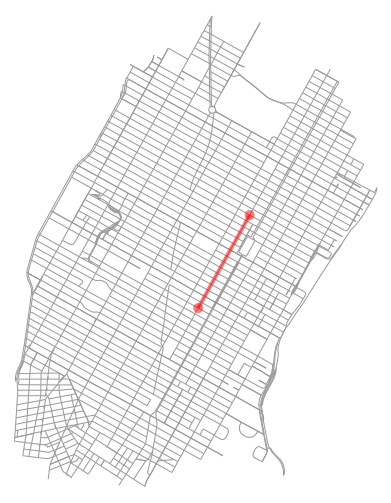

172705    : 15
support   : 2.11 %
distance  : 1200.3470000000002
o_d       : (42430304, 42430356)


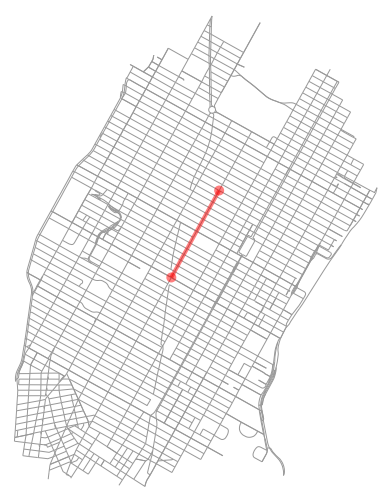

172704    : 15
support   : 2.15 %
distance  : 1195.5880000000002
o_d       : (42437358, 42434800)


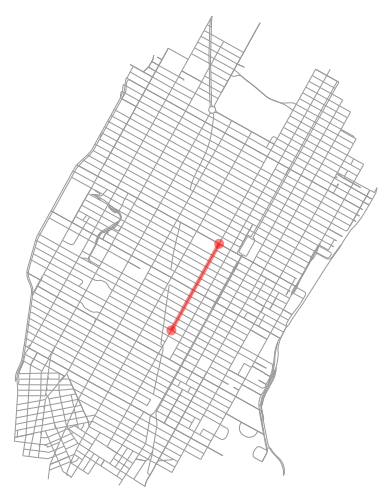

172567    : 14
support   : 2.11 %
distance  : 1126.341
o_d       : (42430295, 42430347)


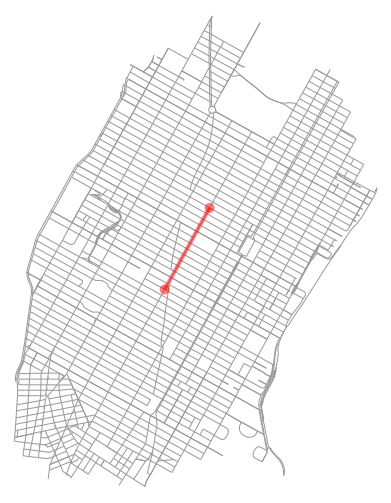

172342    : 13
support   : 2.28 %
distance  : 1039.897
o_d       : (42445908, 42438881)


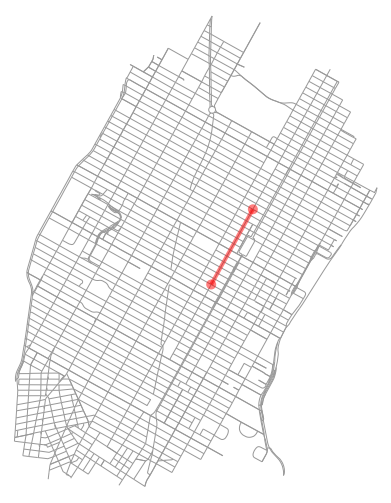

170632    : 12
support   : 2.11 %
distance  : 963.6980000000002
o_d       : (42445651, 42440453)


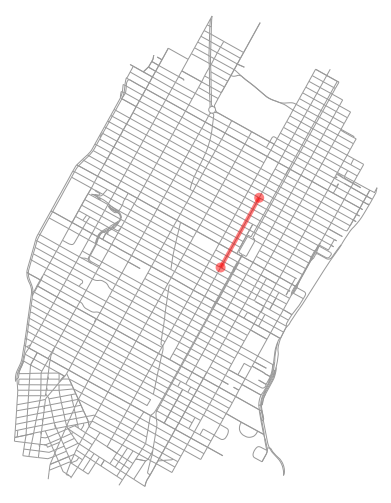

168774    : 11
support   : 2.01 %
distance  : 876.3499999999999
o_d       : (42445404, 42432438)


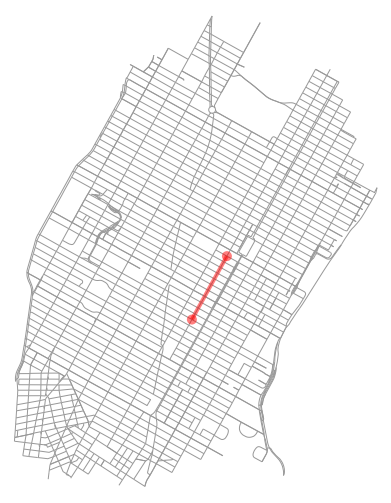

164043    : 11
support   : 2.23 %
distance  : 885.462
o_d       : (42430320, 42430358)


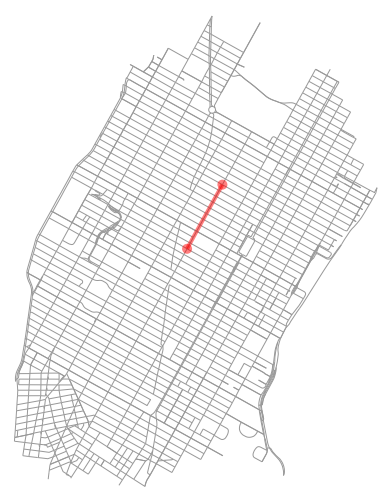

162611    : 11
support   : 2.08 %
distance  : 1102.6060000000002
o_d       : (42430295, 42445914)


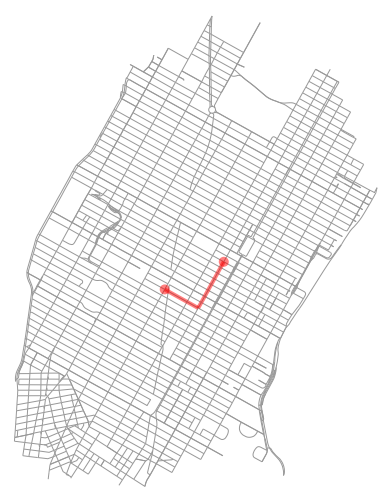

162258    : 11
support   : 2.08 %
distance  : 874.894
o_d       : (42443950, 42429874)


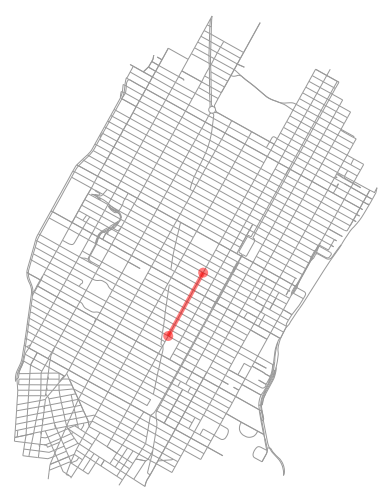

In [119]:
repo_seq=set()
paths=collections.defaultdict(list)
count = 1
for each_row in frequent_itemsets_link.iloc[::-1].iterrows():
    base_seq = each_row[1]['itemsets']
    if len(base_seq)>10:
        if any(set(base_seq).issubset(_) for _ in repo_seq) or\
           any(len(set(base_seq).intersection(_))/len(_)>.9 for _ in repo_seq):
            continue
        repo_seq.add(base_seq)
        node_from_link=[_[0] for _ in base_seq]
        node_from_link_1=[_[1] for _ in base_seq]
        [node_from_link.extend([_]) for _ in node_from_link_1 if _ not in node_from_link]
        for o_d in itertools.combinations(node_from_link,2):
            ridero = NYC.node[o_d[0]]['y'], NYC.node[o_d[0]]['x']
            riderd = NYC.node[o_d[1]]['y'], NYC.node[o_d[1]]['x']
            path=route(ridero,riderd)
            paths[len(base_seq)].append(path)
            if set([(path[i],path[i+1]) for i in range(len(path)-1)])==set(base_seq):
                print('{:<10}: {}'.format(each_row[0],each_row[1]['length']))
                print('{:<10}: {:.2f} %'.format('support',each_row[1]['support']*100))
                print('{:10}: {}'.format('distance', distance(ridero,riderd)))
                print('{:10}: {}'.format('o_d',o_d))
                fig, ax = ox.plot_graph_route(NYC, path, node_size=0,fig_height=9, fig_width=16)
                fig.savefig('{}-{}.svg'.format(round(distance(ridero,riderd),2),round(each_row[1]['support']*100,2)),bbox_inches='tight', pad_inches=0.1)
                plt.close()
                count+=1
                print('='*70)

In [ ]:
frequent_itemsets_link.sort_values('support',ascending=False).head()
sec=list(frequent_itemsets_link.loc[17]['itemsets'])[0]
fig,ax = ox.plot_graph(NYC, fig_height=9, fig_width=16, node_size=3, node_color='#66cc66', 
                        node_edgecolor='w', node_zorder=1, edge_alpha=.5, show=False, close=False)
ax.plot([NYC.node[sec[0]]['x'],NYC.node[sec[1]]['x']], 
        [NYC.node[sec[0]]['y'],NYC.node[sec[1]]['y']], 
        linewidth=5,c='r')
fig.savefig('critical link.svg',bbox_inches='tight', pad_inches=0.1)

In [ ]:
fig, ax = ox.plot_graph(NYC, fig_height=25, fig_width=30, node_size=3, node_color='#66cc66', 
                        node_edgecolor='w', node_zorder=1, edge_alpha=.5, show=False, close=False)
path = {k:v for k,v in frequent_itemsets_link_dict.items() if k==16}
cmap_list = ['gist_rainbow','Spectral','plasma','nipy_spectral','jet','rainbow','brg']
cmap = plt.get_cmap(cmap_list[-1])
colors = cmap(np.linspace(0, 1.0, len(path)))
# alpha=np.linspace(.3, 1, len(path)).tolist()
alpha=[k/(list(frequent_itemsets_link['length'])[-1]) for k in path]
for k, c, a in zip(path,colors,alpha):
    for section in path[k]:
        ax.plot([NYC.node[section[0]]['x'],NYC.node[section[1]]['x']], 
                [NYC.node[section[0]]['y'],NYC.node[section[1]]['y']], 
                c=c, label='{}'.format(section),linewidth=1.5,alpha=a)

fig.savefig('apriori.svg',bbox_inches='tight', pad_inches=0.1)


In [ ]:
te = TransactionEncoder()
te_ary = te.fit(records_nodes).transform(records_nodes)
df_nodes = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets_node = apriori(df_nodes, min_support=.05, use_colnames=True)
frequent_itemsets_node['length'] = frequent_itemsets_node['itemsets'].apply(lambda x: len(x))

frequent_itemsets_node_dict = {i: list() for i in range(1,  list(frequent_itemsets_node['length'])[-1]+ 1)}
for each_row in frequent_itemsets_node.iterrows():
    for node in list(each_row[1]['itemsets']):
        if node in frequent_itemsets_node_dict[each_row[1]['length']]:
            pass
        else:
            frequent_itemsets_node_dict[each_row[1]['length']].append(node)

len(frequent_itemsets_node_dict)

# Dataset summary 

In [ ]:
# what sized area does our network cover in square meters?
NYC1_proj = ox.project_graph(NYC1)
nodes_proj = ox.graph_to_gdfs(NYC1_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
print(graph_area_m)

In [ ]:
from pprint import pprint
basic_stats = ox.basic_stats(NYC1_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')
pprint(basic_stats)

In [ ]:
# highlight all the one-way edges in the mission district network from earlier
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in NYC1.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(NYC1, fig_height=30, fig_width=35, node_size=0, 
                        edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

red_patch = mpatches.Patch(color='red', label='one-way')
blue_patch = mpatches.Patch(color='blue', label='two-way')
ax.legend(loc='upper left', handles=[red_patch,blue_patch], prop={'size': 20},bbox_to_anchor=(0., 0.8))
fig.savefig('visual/network.png',dpi=200)
ax.get_figure()

# Instance for routing

In [ ]:
passenger = [76, 47, 86, 40]
taxi = 8

In [ ]:
tile = ['Stamen Terrain', 'Stamen Toner', 'Stamen Watercolor', 
        'OpenStreetMap', 
        'Mapbox Bright', 
        'CartoDB positron', 
        'CartoDB dark_matter']


map_ = folium.Map(location=(40.751738, -73.987042), tiles=tile[5], zoom_start=14)
marker_cluster_ = MarkerCluster().add_to(map_)

# add a marker for every record in the filtered data, use a clustered view
for each in ds_rider.iterrows():
    lat, lon = [each[1]['p_lat'], each[1]['p_lon']]
    if each[0] in [0, 39, 50, 97, 2, 34, 25, 65, 36, 96, 16, 10, 3, 73, 19, 20, 63, 74, 43, 56, 71, 72, 85, 4, 13, 26, 84, 75, 70, 24, 41, 8, 23, 37, 32, 79, 64, 27, 22, 62, 69, 91, 5, 14, 78, 38, 92]:
        pass
    elif each[0] in [3, 15, 32, 33, 35, 38, 40, 42, 47, 58, 67, 72, 73, 76, 85, 86, 93, 95]:
        folium.Marker([lat, lon], 
                      popup='lat: {}<br>lon: {}'.format(lat, lon), 
                      icon=folium.Icon(color='green', icon_color='white', icon='thumbs-up', prefix='fa'), 
                      tooltip=str(each[0])).add_to(map_)
    else:
        folium.Marker([lat, lon], 
                      popup='lat: {}<br>lon: {}'.format(lat, lon), 
                      icon=folium.Icon(color='blue', icon_color='white', icon='thumbs-up', prefix='fa'), 
                      tooltip=str(each[0])).add_to(map_)

# add a marker for every record in the filtered data, use a clustered view
for each in ds_taxi.iterrows():
    lat, lon = [each[1]['p_lat'], each[1]['p_lon']]
    if each[0] in [taxi]:
        folium.Marker([lat, lon], 
                      popup='lat: {}<br>lon: {}'.format(lat, lon), 
                      icon=folium.Icon(color='purple', icon_color='white', icon='taxi', prefix='fa'), 
                      tooltip=str(each[0])).add_to(map_)
        folium.Circle([lat, lon],radius=600).add_to(map_)
display(map_)

In [ ]:
lat_in_o = [ds_rider['p_lat'][each_rider] for each_rider in passenger]
lon_in_o = [ds_rider['p_lon'][each_rider] for each_rider in passenger]
cor_o = [sum(lat_in_o)/len(lat_in_o), sum(lon_in_o)/len(lon_in_o)]

lat_in_d = [ds_rider['d_lat'][each_rider] for each_rider in passenger]
lon_in_d = [ds_rider['d_lon'][each_rider] for each_rider in passenger]
cor_d = list((sum(lat_in_d)/len(lat_in_d), sum(lon_in_d)/len(lon_in_d)))

tile = ['Stamen Terrain', 'Stamen Toner', 'Stamen Watercolor', 
        'OpenStreetMap', 
        'Mapbox Bright', 
        'CartoDB positron', 
        'CartoDB dark_matter']
map_ = folium.Map(location=(40.751738, -73.987042), tiles=tile[5], zoom_start=15)
marker_cluster_ = MarkerCluster().add_to(map_)

# add a marker for every record in the filtered data, use a clustered view
for each in ds_rider.iterrows():
    lat_o, lon_o = [each[1]['p_lat'], each[1]['p_lon']]
    lat_d, lon_d = [each[1]['d_lat'], each[1]['d_lon']]
    if each[0] in passenger:
        folium.Marker([lat_o, lon_o], 
                      popup='lat: {}<br>lon: {}'.format(lat_o, lon_o), 
                      icon=folium.Icon(color='green', icon_color='white', icon='thumbs-up', prefix='fa'), 
                      tooltip=str(each[0])).add_to(map_)
        folium.Marker([lat_d, lon_d], 
                      popup='lat: {}<br>lon: {}'.format(lat_d, lon_d), 
                      icon=folium.Icon(color='blue', icon_color='white', icon='thumbs-down', prefix='fa'), 
                      tooltip=str(each[0])).add_to(map_)

# add a marker for every record in the filtered data, use a clustered view
for each in ds_taxi.iterrows():
    lat, lon = [each[1]['p_lat'], each[1]['p_lon']]
    if each[0] in [taxi]:
        folium.CircleMarker([lat, lon],radius=4,color='red').add_to(map_)
        folium.CircleMarker(cor_o,radius=4,color='green').add_to(map_)
        folium.PolyLine(locations=[[lat, lon],cor_o],color='blue',no_clip=True).add_to(map_)
display(map_)

In [ ]:
lat_in_o = [ds_rider['p_lat'][each_rider] for each_rider in passenger]
lon_in_o = [ds_rider['p_lon'][each_rider] for each_rider in passenger]
cor_o = [sum(lat_in_o)/len(lat_in_o), sum(lon_in_o)/len(lon_in_o)]

lat_in_d = [ds_rider['d_lat'][each_rider] for each_rider in passenger]
lon_in_d = [ds_rider['d_lon'][each_rider] for each_rider in passenger]
cor_d = list((sum(lat_in_d)/len(lat_in_d), sum(lon_in_d)/len(lon_in_d)))

tile = ['Stamen Terrain', 'Stamen Toner', 'Stamen Watercolor', 
        'OpenStreetMap', 
        'Mapbox Bright', 
        'CartoDB positron', 
        'CartoDB dark_matter']
map_ = folium.Map(location=(40.751738, -73.987042), tiles=tile[5], zoom_start=15)
marker_cluster_ = MarkerCluster().add_to(map_)

# add a marker for every record in the filtered data, use a clustered view
for each in ds_rider.iterrows():
    lat_o, lon_o = [each[1]['p_lat'], each[1]['p_lon']]
    lat_d, lon_d = [each[1]['d_lat'], each[1]['d_lon']]
    if each[0] in passenger:
        folium.Marker([lat_o, lon_o], 
                      popup='lat: {}<br>lon: {}'.format(lat_o, lon_o), 
                      icon=folium.Icon(color='green', icon_color='white', icon='thumbs-up', prefix='fa'), 
                      tooltip=str(each[0])).add_to(map_)
        folium.PolyLine(locations=[[lat_o, lon_o],cor_o],color='blue',no_clip=True).add_to(map_)
        folium.Marker([lat_d, lon_d], 
                      popup='lat: {}<br>lon: {}'.format(lat_d, lon_d), 
                      icon=folium.Icon(color='blue', icon_color='white', icon='thumbs-down', prefix='fa'), 
                      tooltip=str(each[0])).add_to(map_)
        folium.PolyLine(locations=[[lat_d, lon_d],cor_d],color='blue',no_clip=True).add_to(map_)
display(map_)

In [ ]:
NYC = ox.graph_from_bbox(40.764375, 40.738909, -73.960251, -73.999350, show=False,
                          simplify=True, retain_all=False, network_type='drive', clean_periphery=True)
routes = {key:[] for key in passenger}
# origin
rider76 = 76
rider47 = 47
rider86 = 86
rider40 = 40

orig_node = ox.get_nearest_node(NYC, [ds_taxi['p_lat'][taxi], ds_taxi['p_lon'][taxi]])
dest_node = ox.get_nearest_node(NYC, [ds_rider['p_lat'][rider76], ds_rider['p_lon'][rider76]])
routes[76].append(nx.shortest_path(NYC,orig_node,dest_node))
# destination
orig_node = ox.get_nearest_node(NYC, [ds_rider['d_lat'][rider47], ds_rider['d_lon'][rider47]])
dest_node = ox.get_nearest_node(NYC, [ds_rider['d_lat'][rider76], ds_rider['d_lon'][rider76]])
routes[76].append(nx.shortest_path(NYC,orig_node,dest_node))

# origin
orig_node = ox.get_nearest_node(NYC, [ds_rider['p_lat'][rider76], ds_rider['p_lon'][rider76]])
dest_node = ox.get_nearest_node(NYC, [ds_rider['p_lat'][rider47], ds_rider['p_lon'][rider47]])
routes[47].append(nx.shortest_path(NYC,orig_node,dest_node))
# destination
orig_node = ox.get_nearest_node(NYC, [ds_rider['d_lat'][rider40], ds_rider['d_lon'][rider40]])
dest_node = ox.get_nearest_node(NYC, [ds_rider['d_lat'][rider47], ds_rider['d_lon'][rider47]])
routes[47].append(nx.shortest_path(NYC,orig_node,dest_node))

# origin
orig_node = ox.get_nearest_node(NYC, [ds_rider['p_lat'][rider47], ds_rider['p_lon'][rider47]])
dest_node = ox.get_nearest_node(NYC, [ds_rider['p_lat'][rider86], ds_rider['p_lon'][rider86]])
routes[86].append(nx.shortest_path(NYC,orig_node,dest_node))
# destination
orig_node = ox.get_nearest_node(NYC, [ds_rider['p_lat'][rider40], ds_rider['p_lon'][rider40]])
dest_node = ox.get_nearest_node(NYC, [ds_rider['d_lat'][rider86], ds_rider['d_lon'][rider86]])
routes[86].append(nx.shortest_path(NYC,orig_node,dest_node))

# origin
orig_node = ox.get_nearest_node(NYC, [ds_rider['p_lat'][rider86], ds_rider['p_lon'][rider86]])
dest_node = ox.get_nearest_node(NYC, [ds_rider['p_lat'][rider40], ds_rider['p_lon'][rider40]])
routes[40].append(nx.shortest_path(NYC,orig_node,dest_node))
# destination
orig_node = ox.get_nearest_node(NYC, [ds_rider['d_lat'][rider86], ds_rider['d_lon'][rider86]])
dest_node = ox.get_nearest_node(NYC, [ds_rider['d_lat'][rider40], ds_rider['d_lon'][rider40]])
routes[40].append(nx.shortest_path(NYC,orig_node,dest_node))

Color = ['dimgray','red','blue','green']  
color_route = []
counter=0
for key in routes:
    for each_route in routes[key]:
        color_route += ([Color[counter]]*len(each_route))[1:]
    counter+=1
    
color_node = []
counter=0
for key in routes:
    for each_route in routes[key]:
        color_node += [Color[counter]]*2
    counter+=1
    
routes_list = []
for v in routes.values():
    routes_list+=v

fig_route, ax_route = ox.plot_graph_routes(NYC, routes_list, fig_height=25, fig_width=30, 
                                           node_size=5, node_color='black', node_edgecolor='w', 
                                           edge_alpha=1, edge_linewidth=1.5,
                                           route_linewidth=7, route_color=color_route, 
                                           route_alpha=1, orig_dest_node_size=150, 
                                           orig_dest_node_color=color_node, orig_dest_node_alpha=.5)


to_first = mpatches.Patch(color='dimgray', label='id=76,  vkt=3659.055,  detour_factor=1.71')
to_sec = mpatches.Patch(color='red', label='id=47,  vkt=3060.104,  detour_factor=1.12')
to_third = mpatches.Patch(color='blue', label='id=86,  vkt=1954.762,  detour_factor=1.01')
to_fourth = mpatches.Patch(color='green', label='id=40,  vkt=1589.136,  detuor_factor=1.25')

ax_route.legend(loc='lower left', handles=[to_first,to_sec,to_third,to_fourth], 
                prop={'size': 25},bbox_to_anchor=(0.3, -.15))
fig_route.savefig('visual/routing.png',dpi=300)
ax_route.get_figure()